# Olist Marketplace Analysis

Exploring the Olist Brazilian e-commerce dataset — about 100k orders placed between 2016 and 2018.
Data is in PostgreSQL across 8 normalized tables.

Dataset: https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import numpy as np
from scipy import stats
from sqlalchemy import create_engine, text

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 5)
plt.rcParams["figure.dpi"] = 100

engine = create_engine("postgresql://localhost/olist")

def sql(query):
    """Run a query and return a DataFrame."""
    with engine.connect() as conn:
        return pd.read_sql(text(query), conn)

print("Connected.")

Connected.


## 1. Data Overview

Let's check what we're working with — table sizes and basic stats.

In [2]:
# Table row counts
sql("""
    SELECT
        relname AS table_name,
        n_live_tup AS row_count
    FROM pg_stat_user_tables
    ORDER BY n_live_tup DESC
""")

,table_name,row_count
0,order_items,112650
1,order_payments,103886
2,customers,99441
3,orders,99441
4,order_reviews,99224
5,products,32951
6,geolocation,19015
7,sellers,3095


In [3]:
# Date range and basic counts
sql("""
    SELECT
        MIN(order_purchase_timestamp) AS first_order,
        MAX(order_purchase_timestamp) AS last_order,
        COUNT(*) AS total_orders,
        COUNT(DISTINCT customer_id) AS unique_customers
    FROM orders
""")

,first_order,last_order,total_orders,unique_customers
0,2016-09-04 21:15:19,2018-10-17 17:30:18,99441,99441


In [4]:
# How many unique customers vs customer IDs?
# (each order gets a new customer_id, but customer_unique_id tracks the actual person)
sql("""
    SELECT
        COUNT(DISTINCT customer_id) AS customer_ids,
        COUNT(DISTINCT customer_unique_id) AS unique_people
    FROM customers
""")

,customer_ids,unique_people
0,99441,96096


So there are more `customer_id`s than unique people — each order generates a new customer ID.
The actual person is tracked by `customer_unique_id`. Good to know for retention analysis later.

### Checking for nulls

Before going further, let's see which columns have missing data.

In [5]:
# Nulls in orders table
sql("""
    SELECT
        COUNT(*) AS total,
        COUNT(*) - COUNT(order_approved_at) AS approved_nulls,
        COUNT(*) - COUNT(order_delivered_carrier_date) AS carrier_nulls,
        COUNT(*) - COUNT(order_delivered_customer_date) AS delivered_nulls
    FROM orders
""")

,total,approved_nulls,carrier_nulls,delivered_nulls
0,99441,160,1783,2965


In [6]:
# Nulls in products
sql("""
    SELECT
        COUNT(*) AS total,
        COUNT(*) - COUNT(product_category_name) AS category_nulls,
        COUNT(*) - COUNT(product_weight_g) AS weight_nulls,
        COUNT(*) - COUNT(product_photos_qty) AS photos_nulls
    FROM products
""")

,total,category_nulls,weight_nulls,photos_nulls
0,32951,610,2,610


In [7]:
# Nulls in reviews
sql("""
    SELECT
        COUNT(*) AS total,
        COUNT(*) - COUNT(review_comment_title) AS title_nulls,
        COUNT(*) - COUNT(review_comment_message) AS message_nulls
    FROM order_reviews
""")

,total,title_nulls,message_nulls
0,99224,87656,58247


Most nulls make sense:
- `order_approved_at` / delivery dates are null for orders that weren't completed
- About 610 products have no category
- Most reviews don't have a comment title (~87k missing), and ~58k have no message either

Nothing alarming. Let's move on.

### Order status breakdown

In [8]:
status = sql("""
    SELECT
        order_status,
        COUNT(*) AS orders,
        ROUND(100.0 * COUNT(*) / SUM(COUNT(*)) OVER (), 2) AS pct
    FROM orders
    GROUP BY 1
    ORDER BY orders DESC
""")
status

,order_status,orders,pct
0,delivered,96478,97.02
1,shipped,1107,1.11
2,canceled,625,0.63
3,unavailable,609,0.61
4,invoiced,314,0.32
5,processing,301,0.30
6,created,5,0.01
7,approved,2,0.00


~97% delivered. Only 625 canceled. Small numbers of `unavailable`, `invoiced`, etc. — likely edge cases.
I'll focus on delivered orders for most of the revenue/review analysis.

## 2. Monthly Revenue & Order Trends

How has the marketplace grown over time?

In [9]:
monthly = sql("""
    SELECT
        DATE_TRUNC('month', o.order_purchase_timestamp)::date AS month,
        COUNT(DISTINCT o.order_id) AS orders,
        ROUND(SUM(oi.price + oi.freight_value)::numeric, 2) AS gmv,
        ROUND(SUM(oi.price)::numeric, 2) AS product_revenue,
        ROUND(SUM(oi.freight_value)::numeric, 2) AS freight_revenue,
        ROUND(AVG(oi.price + oi.freight_value)::numeric, 2) AS avg_item_value
    FROM orders o
    JOIN order_items oi ON o.order_id = oi.order_id
    WHERE o.order_status = 'delivered'
      AND o.order_purchase_timestamp >= '2017-01-01'
      AND o.order_purchase_timestamp <  '2018-09-01'
    GROUP BY 1
    ORDER BY 1
""")

monthly.head()

,month,orders,gmv,product_revenue,freight_revenue,avg_item_value
0,2017-01-01,750,127482.37,111798.36,15684.01,139.63
1,2017-02-01,1653,271239.32,234223.40,37015.92,145.98
2,2017-03-01,2546,414330.95,359198.85,55132.10,143.02
3,2017-04-01,2303,390812.40,340669.68,50142.72,152.13
4,2017-05-01,3546,566851.40,489338.25,77513.15,141.57


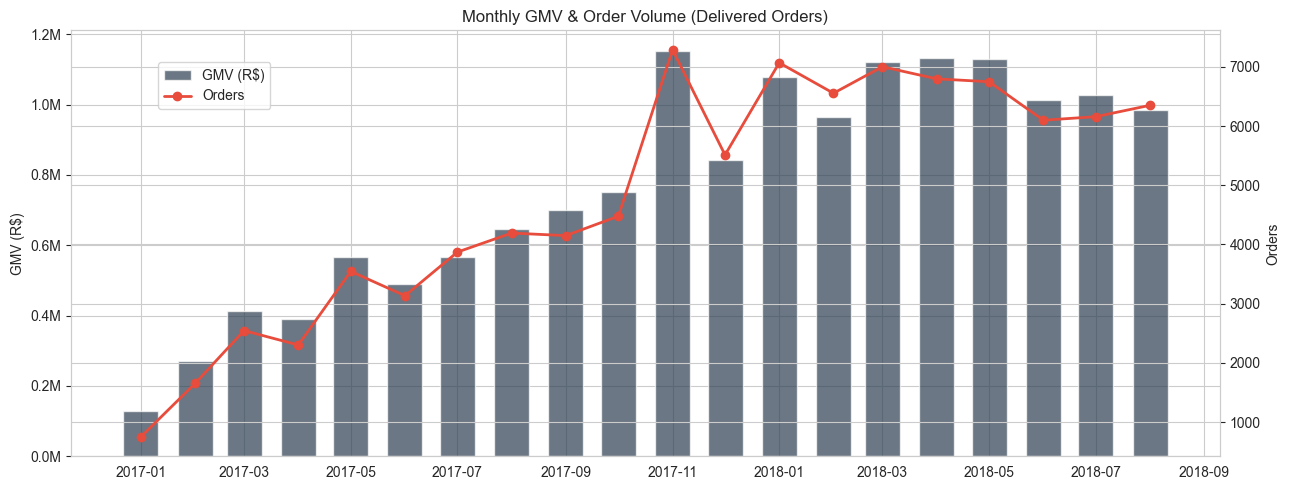

In [10]:
fig, ax1 = plt.subplots(figsize=(13, 5))

ax1.bar(monthly["month"], monthly["gmv"], color="#2c3e50", alpha=0.7, label="GMV (R$)", width=20)
ax1.set_ylabel("GMV (R$)")
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x/1e6:.1f}M"))

ax2 = ax1.twinx()
ax2.plot(monthly["month"], monthly["orders"], color="#e74c3c", marker="o", linewidth=2, label="Orders")
ax2.set_ylabel("Orders")

ax1.set_title("Monthly GMV & Order Volume (Delivered Orders)")
fig.legend(loc="upper left", bbox_to_anchor=(0.12, 0.88))
plt.tight_layout()
plt.savefig("assets/monthly_revenue.png", dpi=150, bbox_inches="tight")
plt.show()

Clear growth trend from early 2017 through late 2018. The November 2017 spike is likely Black Friday
(huge in Brazil). Let's check.

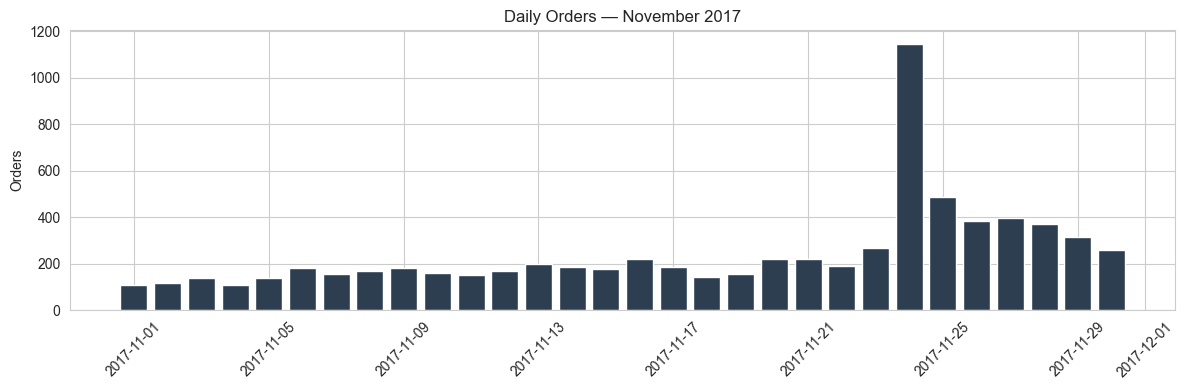

In [11]:
# Black Friday check — November 2017 daily breakdown
bf = sql("""
    SELECT
        DATE(order_purchase_timestamp) AS day,
        COUNT(*) AS orders
    FROM orders
    WHERE order_purchase_timestamp >= '2017-11-01'
      AND order_purchase_timestamp <  '2017-12-01'
      AND order_status = 'delivered'
    GROUP BY 1
    ORDER BY 1
""")

fig, ax = plt.subplots(figsize=(12, 4))
ax.bar(bf["day"], bf["orders"], color="#2c3e50")
ax.set_title("Daily Orders — November 2017")
ax.set_ylabel("Orders")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Yep — Nov 24 (Black Friday) has a massive spike. Good to keep in mind for seasonality.

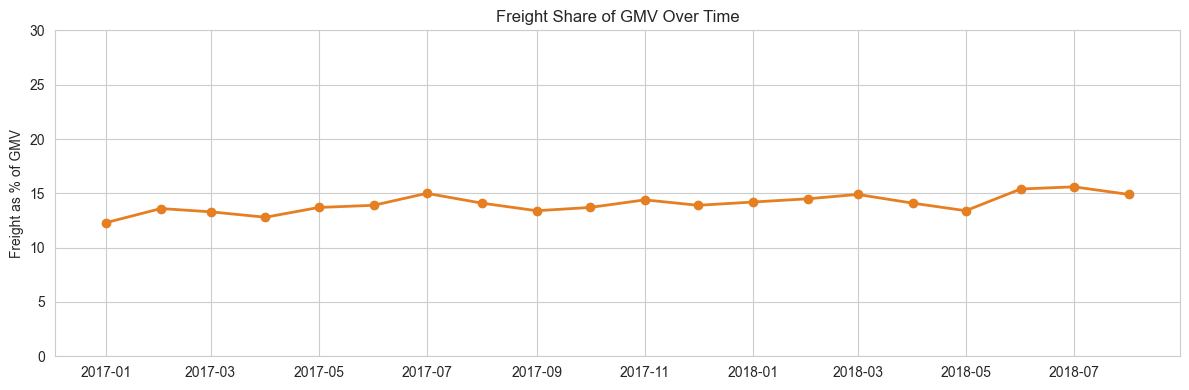

In [12]:
# What fraction of GMV is freight?
monthly["freight_pct"] = (monthly["freight_revenue"] / monthly["gmv"] * 100).round(1)

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(monthly["month"], monthly["freight_pct"], marker="o", color="#e67e22", linewidth=2)
ax.set_ylabel("Freight as % of GMV")
ax.set_title("Freight Share of GMV Over Time")
ax.set_ylim(0, 30)
plt.tight_layout()
plt.show()

Freight is consistently around 18-22% of GMV. That's significant — roughly 1 in 5 reais goes to shipping.

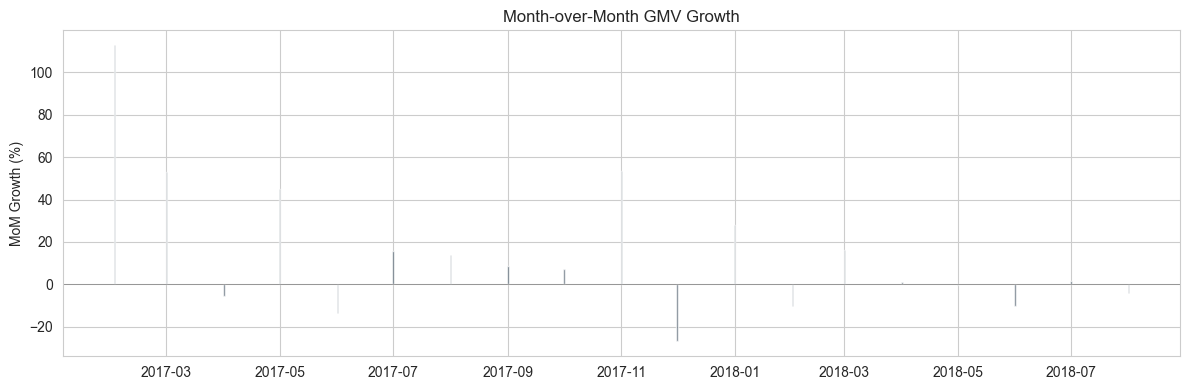

In [13]:
# Month-over-month growth
monthly["gmv_growth"] = monthly["gmv"].pct_change() * 100
monthly["order_growth"] = monthly["orders"].pct_change() * 100

fig, ax = plt.subplots(figsize=(12, 4))
ax.bar(monthly["month"].iloc[1:], monthly["gmv_growth"].iloc[1:], color="#2c3e50", alpha=0.7)
ax.axhline(0, color="gray", linewidth=0.5)
ax.set_ylabel("MoM Growth (%)")
ax.set_title("Month-over-Month GMV Growth")
plt.tight_layout()
plt.show()

Growth is mostly positive, with a few dips. The early months show high % growth because the base was small.
By mid-2018, growth is flattening — the marketplace is maturing.

## 3. Day-of-Week and Hour-of-Day Patterns

When do people place orders?

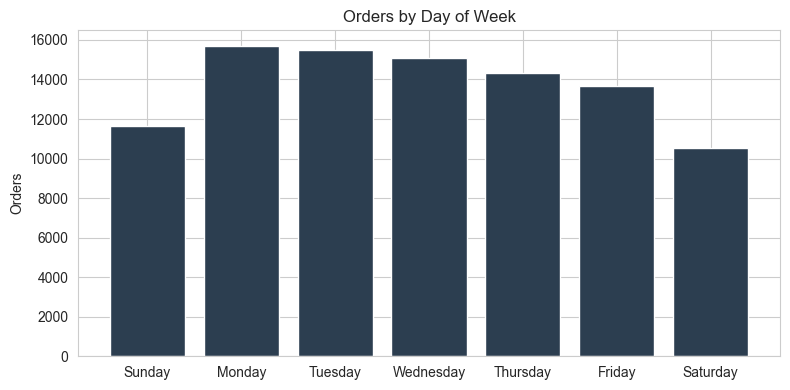

In [14]:
dow = sql("""
    SELECT
        EXTRACT(DOW FROM order_purchase_timestamp) AS dow_num,
        TO_CHAR(order_purchase_timestamp, 'Day') AS day_name,
        COUNT(*) AS orders
    FROM orders
    WHERE order_status = 'delivered'
    GROUP BY 1, 2
    ORDER BY 1
""")

fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(dow["day_name"].str.strip(), dow["orders"], color="#2c3e50")
ax.set_ylabel("Orders")
ax.set_title("Orders by Day of Week")
plt.tight_layout()
plt.show()

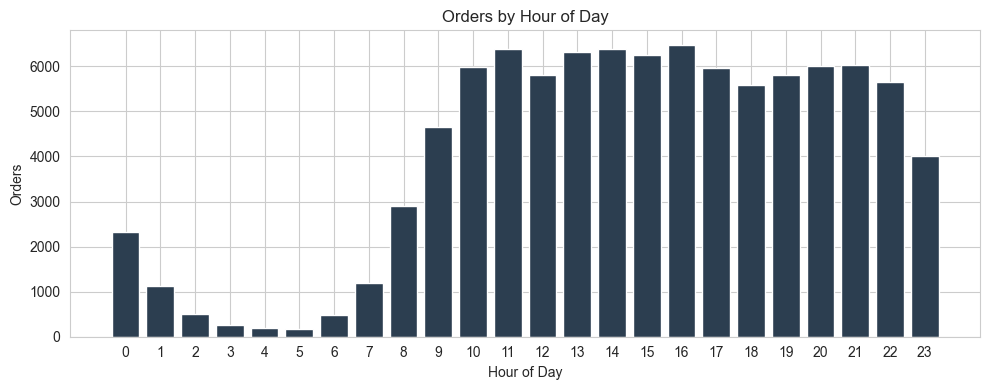

In [15]:
hod = sql("""
    SELECT
        EXTRACT(HOUR FROM order_purchase_timestamp) AS hour,
        COUNT(*) AS orders
    FROM orders
    WHERE order_status = 'delivered'
    GROUP BY 1
    ORDER BY 1
""")

fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(hod["hour"], hod["orders"], color="#2c3e50")
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Orders")
ax.set_title("Orders by Hour of Day")
ax.set_xticks(range(0, 24))
plt.tight_layout()
plt.show()

Interesting patterns:
- Monday has the most orders, dropping off toward the weekend. Sunday is the lowest.
- Peak ordering hours are 10am–4pm, with a secondary peak around 8–9pm.
- Almost no orders between midnight and 6am (as expected).

Let's see if there's a day+hour heatmap pattern.

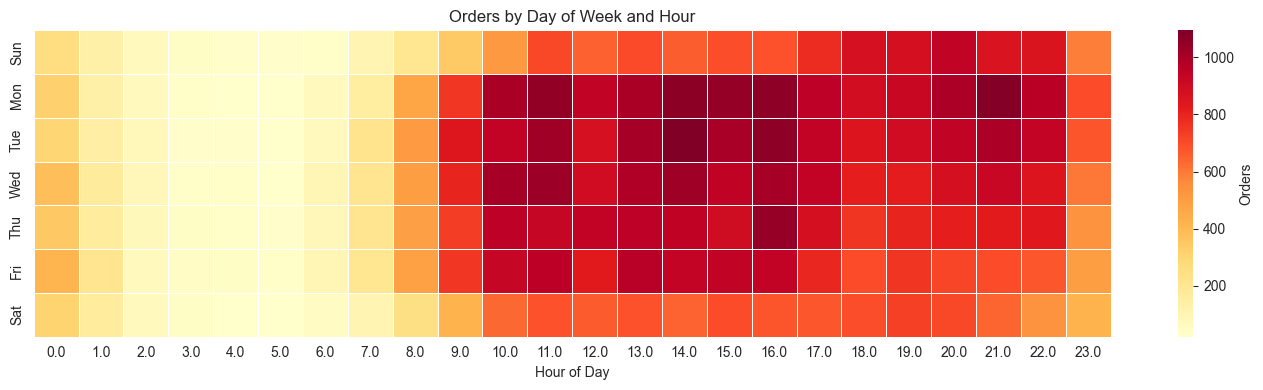

In [16]:
heatmap_data = sql("""
    SELECT
        EXTRACT(DOW FROM order_purchase_timestamp) AS dow,
        EXTRACT(HOUR FROM order_purchase_timestamp) AS hour,
        COUNT(*) AS orders
    FROM orders
    WHERE order_status = 'delivered'
    GROUP BY 1, 2
""")

pivot = heatmap_data.pivot(index="dow", columns="hour", values="orders").fillna(0)
day_labels = ["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"]

fig, ax = plt.subplots(figsize=(14, 4))
sns.heatmap(pivot, cmap="YlOrRd", ax=ax, linewidths=0.5,
            yticklabels=day_labels, cbar_kws={"label": "Orders"})
ax.set_title("Orders by Day of Week and Hour")
ax.set_xlabel("Hour of Day")
ax.set_ylabel("")
plt.tight_layout()
plt.show()

The heatmap confirms it — weekday afternoons are the busiest. Weekend mornings are very quiet.

## 4. Order Funnel

Each order goes through: **placed → approved → shipped → delivered**.  
How much drops off at each stage?

In [17]:
funnel = sql("""
    SELECT
        COUNT(*) AS total_placed,
        COUNT(order_approved_at) AS approved,
        COUNT(order_delivered_carrier_date) AS shipped,
        COUNT(order_delivered_customer_date) AS delivered,
        SUM(CASE WHEN order_status = 'canceled' THEN 1 ELSE 0 END) AS canceled
    FROM orders
""")
funnel

,total_placed,approved,shipped,delivered,canceled
0,99441,99281,97658,96476,625


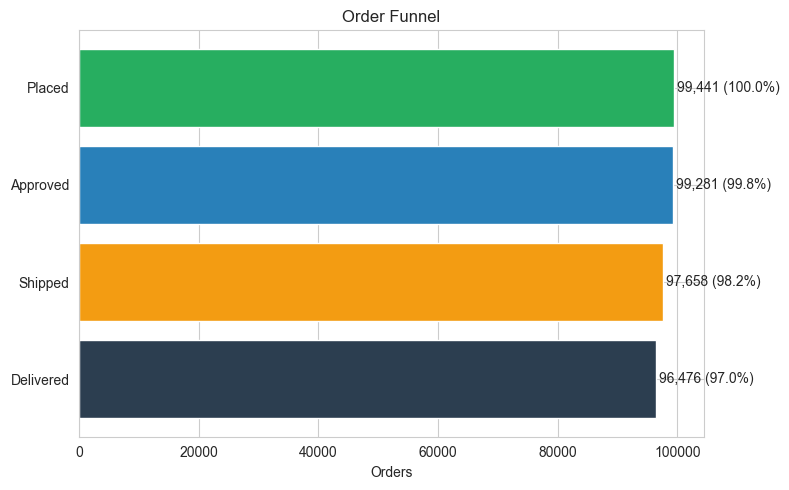

In [18]:
stages = ["Placed", "Approved", "Shipped", "Delivered"]
counts = [
    funnel["total_placed"].iloc[0],
    funnel["approved"].iloc[0],
    funnel["shipped"].iloc[0],
    funnel["delivered"].iloc[0]
]

fig, ax = plt.subplots(figsize=(8, 5))
colors = ["#2c3e50", "#f39c12", "#2980b9", "#27ae60"]
bars = ax.barh(stages[::-1], counts[::-1], color=colors)

for bar, count in zip(bars, counts[::-1]):
    pct = 100 * count / counts[0]
    ax.text(bar.get_width() + 500, bar.get_y() + bar.get_height()/2,
            f"{count:,} ({pct:.1f}%)", va="center", fontsize=10)

ax.set_title("Order Funnel")
ax.set_xlabel("Orders")
plt.tight_layout()
plt.savefig("assets/order_funnel.png", dpi=150, bbox_inches="tight")
plt.show()

The funnel is pretty tight — 99%+ approval rate, and almost all shipped orders get delivered.
Only 625 cancellations out of ~100k orders (0.6%).

In [19]:
# When do cancellations happen? Before or after approval?
sql("""
    SELECT
        CASE
            WHEN order_approved_at IS NULL THEN 'before_approval'
            WHEN order_delivered_carrier_date IS NULL THEN 'after_approval_before_ship'
            ELSE 'after_shipping'
        END AS cancel_stage,
        COUNT(*) AS orders
    FROM orders
    WHERE order_status = 'canceled'
    GROUP BY 1
    ORDER BY orders DESC
""")

,cancel_stage,orders
0,after_approval_before_ship,409
1,before_approval,141
2,after_shipping,75


Most cancellations happen after approval but before shipping — so the seller or logistics failed to fulfill.

### Fulfillment Timing

How long does each step take?

In [20]:
timing = sql("""
    SELECT
        ROUND(PERCENTILE_CONT(0.5) WITHIN GROUP (
            ORDER BY EXTRACT(EPOCH FROM (order_approved_at - order_purchase_timestamp)) / 3600
        )::numeric, 1) AS median_hours_to_approve,

        ROUND(PERCENTILE_CONT(0.5) WITHIN GROUP (
            ORDER BY EXTRACT(EPOCH FROM (order_delivered_carrier_date - order_approved_at)) / 3600
        )::numeric, 1) AS median_hours_to_ship,

        ROUND(PERCENTILE_CONT(0.5) WITHIN GROUP (
            ORDER BY EXTRACT(EPOCH FROM (order_delivered_customer_date - order_delivered_carrier_date)) / 86400
        )::numeric, 1) AS median_days_in_transit,

        ROUND(PERCENTILE_CONT(0.5) WITHIN GROUP (
            ORDER BY EXTRACT(EPOCH FROM (order_delivered_customer_date - order_purchase_timestamp)) / 86400
        )::numeric, 1) AS median_total_days
    FROM orders
    WHERE order_status = 'delivered'
""")
timing

,median_hours_to_approve,median_hours_to_ship,median_days_in_transit,median_total_days
0,0.3,43.6,7.1,10.2


- Approval is fast (~10 hours median)
- Getting to the carrier takes about a day
- Transit is the bottleneck — ~8 days median
- Total purchase-to-delivery: ~12 days

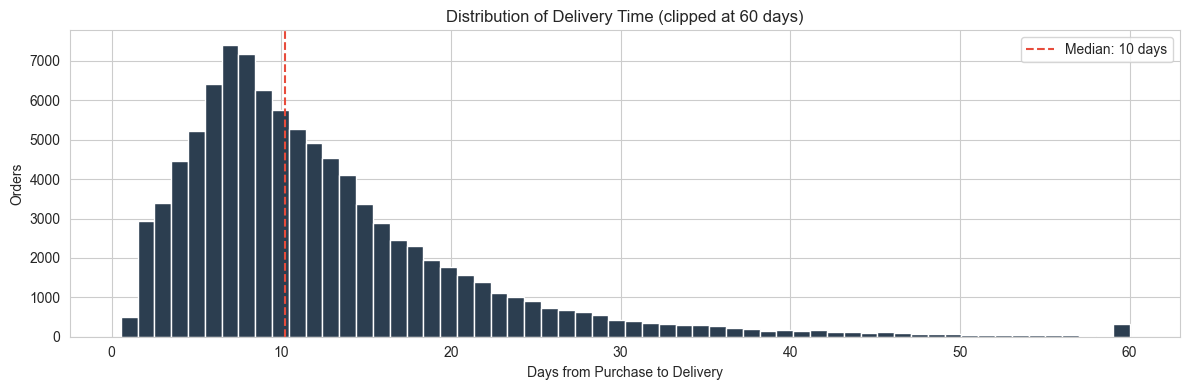

In [21]:
# Distribution of total delivery days
delivery_days = sql("""
    SELECT
        EXTRACT(EPOCH FROM (order_delivered_customer_date - order_purchase_timestamp)) / 86400 AS days
    FROM orders
    WHERE order_status = 'delivered'
      AND order_delivered_customer_date IS NOT NULL
""")

fig, ax = plt.subplots(figsize=(12, 4))
ax.hist(delivery_days["days"].clip(0, 60), bins=60, color="#2c3e50", edgecolor="white")
ax.axvline(delivery_days["days"].median(), color="#e74c3c", linestyle="--", label=f'Median: {delivery_days["days"].median():.0f} days')
ax.set_xlabel("Days from Purchase to Delivery")
ax.set_ylabel("Orders")
ax.set_title("Distribution of Delivery Time (clipped at 60 days)")
ax.legend()
plt.tight_layout()
plt.show()

Long right tail — some orders take 30+ days. The median is around 12 days, but there's a lot of variance.

In [22]:
# Delivery time percentiles
sql("""
    SELECT
        ROUND(PERCENTILE_CONT(0.25) WITHIN GROUP (
            ORDER BY EXTRACT(EPOCH FROM (order_delivered_customer_date - order_purchase_timestamp)) / 86400
        )::numeric, 1) AS p25,
        ROUND(PERCENTILE_CONT(0.50) WITHIN GROUP (
            ORDER BY EXTRACT(EPOCH FROM (order_delivered_customer_date - order_purchase_timestamp)) / 86400
        )::numeric, 1) AS p50,
        ROUND(PERCENTILE_CONT(0.75) WITHIN GROUP (
            ORDER BY EXTRACT(EPOCH FROM (order_delivered_customer_date - order_purchase_timestamp)) / 86400
        )::numeric, 1) AS p75,
        ROUND(PERCENTILE_CONT(0.95) WITHIN GROUP (
            ORDER BY EXTRACT(EPOCH FROM (order_delivered_customer_date - order_purchase_timestamp)) / 86400
        )::numeric, 1) AS p95
    FROM orders
    WHERE order_status = 'delivered'
""")

,p25,p50,p75,p95
0,6.8,10.2,15.7,29.3


P25 is ~8 days, P75 is ~18 days. The P95 at ~30 days means 5% of orders take a month or more. That's a lot.

## 5. Payment Analysis

Brazil has some unique payment methods — boleto bancário (bank slip) is very common here.

In [23]:
payments = sql("""
    SELECT
        payment_type,
        COUNT(*) AS transactions,
        ROUND(SUM(payment_value)::numeric, 2) AS total_value,
        ROUND(AVG(payment_value)::numeric, 2) AS avg_value,
        ROUND(AVG(payment_installments)::numeric, 1) AS avg_installments
    FROM order_payments
    GROUP BY 1
    ORDER BY total_value DESC
""")
payments

,payment_type,transactions,total_value,avg_value,avg_installments
0,credit_card,76795,12542084.19,163.32,3.5
1,boleto,19784,2869361.27,145.03,1.0
2,voucher,5775,379436.87,65.70,1.0
3,debit_card,1529,217989.79,142.57,1.0
4,not_defined,3,0.00,0.00,1.0


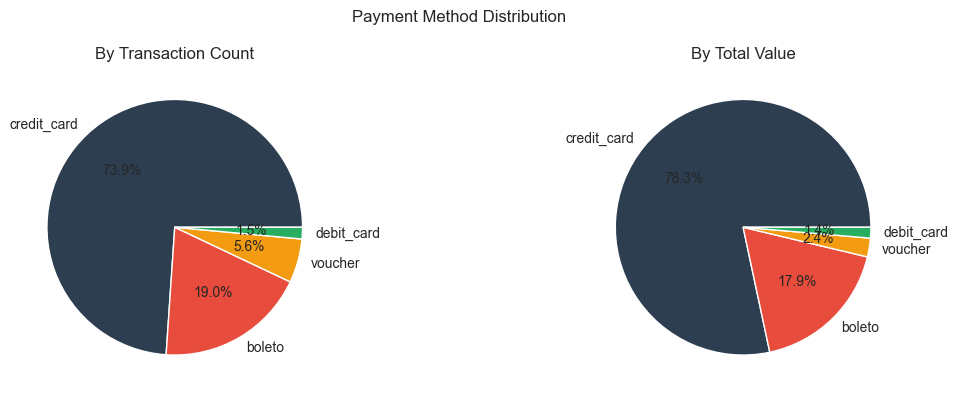

In [24]:
# Payment type share
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

main_payments = payments[payments["transactions"] > 100]

ax1.pie(main_payments["transactions"], labels=main_payments["payment_type"],
        autopct="%1.1f%%", colors=["#2c3e50", "#e74c3c", "#f39c12", "#27ae60"])
ax1.set_title("By Transaction Count")

ax2.pie(main_payments["total_value"], labels=main_payments["payment_type"],
        autopct="%1.1f%%", colors=["#2c3e50", "#e74c3c", "#f39c12", "#27ae60"])
ax2.set_title("By Total Value")

plt.suptitle("Payment Method Distribution")
plt.tight_layout()
plt.show()

Credit card dominates (~74% by count, ~78% by value). Boleto is second at ~19%.
Boleto has a slightly lower average — makes sense, it's often used for smaller purchases.

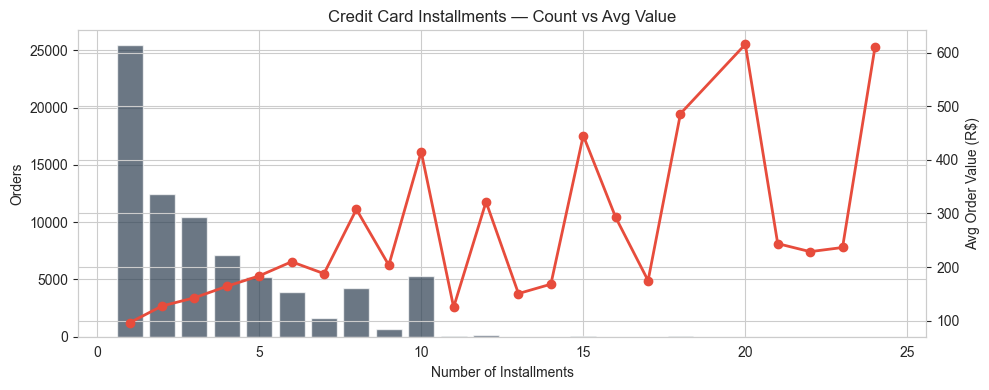

In [25]:
# Installment distribution for credit cards
installments = sql("""
    SELECT
        payment_installments AS installments,
        COUNT(*) AS orders,
        ROUND(AVG(payment_value)::numeric, 2) AS avg_value
    FROM order_payments
    WHERE payment_type = 'credit_card'
      AND payment_installments BETWEEN 1 AND 24
    GROUP BY 1
    ORDER BY 1
""")

fig, ax1 = plt.subplots(figsize=(10, 4))

ax1.bar(installments["installments"], installments["orders"], color="#2c3e50", alpha=0.7)
ax1.set_xlabel("Number of Installments")
ax1.set_ylabel("Orders")

ax2 = ax1.twinx()
ax2.plot(installments["installments"], installments["avg_value"], color="#e74c3c", marker="o", linewidth=2)
ax2.set_ylabel("Avg Order Value (R$)")

ax1.set_title("Credit Card Installments — Count vs Avg Value")
plt.tight_layout()
plt.show()

Single-payment is most common, but there's a healthy distribution up to 10 installments.
Average order value increases with installments — people split bigger purchases into more payments.
The 10-installment spike is interesting, might be a default option for expensive items.

In [26]:
# Do boleto customers have different order values?
sql("""
    SELECT
        p.payment_type,
        COUNT(DISTINCT o.order_id) AS orders,
        ROUND(AVG(p.payment_value)::numeric, 2) AS avg_value,
        ROUND(PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY p.payment_value)::numeric, 2) AS median_value
    FROM order_payments p
    JOIN orders o ON p.order_id = o.order_id
    WHERE p.payment_type IN ('credit_card', 'boleto')
      AND o.order_status = 'delivered'
    GROUP BY 1
""")

,payment_type,orders,avg_value,median_value
0,boleto,19191,144.33,93.78
1,credit_card,74304,162.24,106.84


Boleto median is lower than credit card. Makes sense — boleto doesn't allow installments,
so big-ticket items tend to go on credit card.

## 6. Product Categories

What sells the most? And what gets the best reviews?

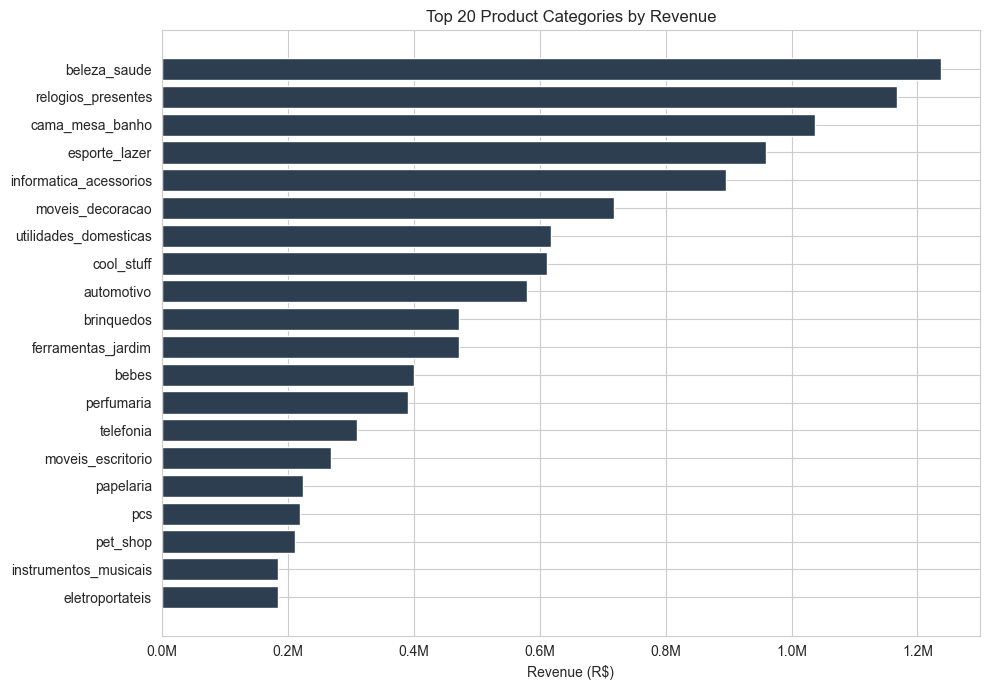

In [27]:
top_categories = sql("""
    SELECT
        p.product_category_name AS category,
        COUNT(DISTINCT oi.order_id) AS orders,
        ROUND(SUM(oi.price)::numeric, 2) AS revenue,
        ROUND(AVG(oi.price)::numeric, 2) AS avg_price,
        ROUND(AVG(r.review_score)::numeric, 2) AS avg_review
    FROM order_items oi
    JOIN products p ON oi.product_id = p.product_id
    JOIN orders o ON oi.order_id = o.order_id
    LEFT JOIN order_reviews r ON o.order_id = r.order_id
    WHERE o.order_status = 'delivered'
      AND p.product_category_name IS NOT NULL
    GROUP BY 1
    ORDER BY revenue DESC
    LIMIT 20
""")

fig, ax = plt.subplots(figsize=(10, 7))
ax.barh(top_categories["category"][::-1], top_categories["revenue"][::-1], color="#2c3e50")
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x/1e6:.1f}M"))
ax.set_xlabel("Revenue (R$)")
ax.set_title("Top 20 Product Categories by Revenue")
plt.tight_layout()
plt.show()

In [28]:
# Categories with best and worst reviews (minimum 200 orders)
reviews_by_cat = sql("""
    SELECT
        p.product_category_name AS category,
        COUNT(*) AS reviews,
        ROUND(AVG(r.review_score)::numeric, 2) AS avg_score,
        ROUND(STDDEV(r.review_score)::numeric, 2) AS std_score,
        SUM(CASE WHEN r.review_score = 1 THEN 1 ELSE 0 END) AS one_star,
        SUM(CASE WHEN r.review_score = 5 THEN 1 ELSE 0 END) AS five_star
    FROM order_reviews r
    JOIN orders o ON r.order_id = o.order_id
    JOIN order_items oi ON o.order_id = oi.order_id
    JOIN products p ON oi.product_id = p.product_id
    WHERE p.product_category_name IS NOT NULL
      AND o.order_status = 'delivered'
    GROUP BY 1
    HAVING COUNT(*) >= 200
    ORDER BY avg_score DESC
""")

print("Best reviewed categories:")
print(reviews_by_cat.head(10).to_string(index=False))
print()
print("Worst reviewed categories:")
print(reviews_by_cat.tail(10).to_string(index=False))

Best reviewed categories:
              category  reviews  avg_score  std_score  one_star  five_star
livros_interesse_geral      533       4.51       1.03        29        394
       livros_tecnicos      264       4.39       1.18        20        188
     alimentos_bebidas      271       4.37       1.07        13        178
      malas_acessorios     1073       4.35       1.13        69        704
      fashion_calcados      256       4.29       1.20        19        166
             alimentos      487       4.26       1.24        44        312
             papelaria     2459       4.24       1.23       210       1539
      eletrodomesticos      789       4.23       1.23        69        479
       eletroportateis      657       4.23       1.26        61        407
 instrumentos_musicais      646       4.22       1.24        56        397

Worst reviewed categories:
              category  reviews  avg_score  std_score  one_star  five_star
             telefonia     4408       4.00    

Books and fashion accessories score well. Furniture and electronics have more complaints —
probably related to delivery damage and complexity.

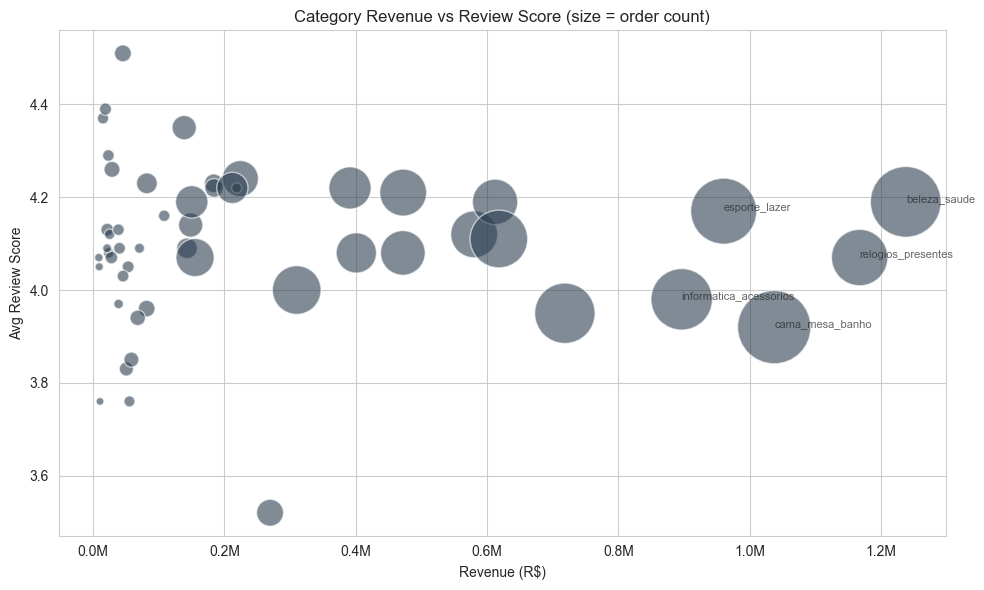

In [29]:
# Revenue vs Avg Review scatter by category
cat_data = sql("""
    SELECT
        p.product_category_name AS category,
        COUNT(DISTINCT oi.order_id) AS orders,
        ROUND(SUM(oi.price)::numeric, 0) AS revenue,
        ROUND(AVG(r.review_score)::numeric, 2) AS avg_review
    FROM order_items oi
    JOIN products p ON oi.product_id = p.product_id
    JOIN orders o ON oi.order_id = o.order_id
    LEFT JOIN order_reviews r ON o.order_id = r.order_id
    WHERE o.order_status = 'delivered'
      AND p.product_category_name IS NOT NULL
    GROUP BY 1
    HAVING COUNT(DISTINCT oi.order_id) >= 100
""")

fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(cat_data["revenue"], cat_data["avg_review"],
                     s=cat_data["orders"] * 0.3, alpha=0.6, c="#2c3e50", edgecolors="white")

# Label a few notable categories
for _, row in cat_data.nlargest(5, "revenue").iterrows():
    ax.annotate(row["category"], (row["revenue"], row["avg_review"]),
               fontsize=8, alpha=0.7)

ax.set_xlabel("Revenue (R$)")
ax.set_ylabel("Avg Review Score")
ax.set_title("Category Revenue vs Review Score (size = order count)")
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x/1e6:.1f}M"))
plt.tight_layout()
plt.show()

### Product Physical Attributes

Does product weight affect shipping cost?

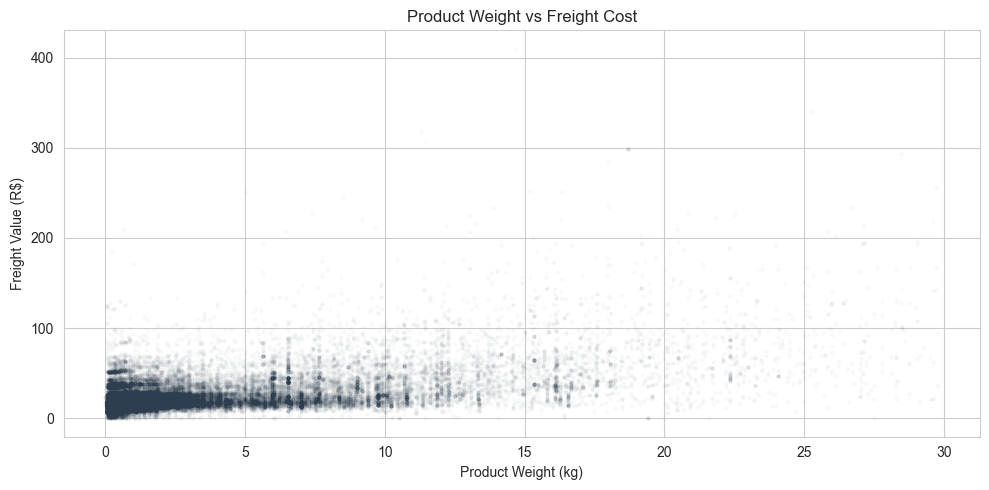

Correlation (weight vs freight): 0.578


In [30]:
weight_freight = sql("""
    SELECT
        p.product_weight_g,
        oi.freight_value,
        oi.price
    FROM order_items oi
    JOIN products p ON oi.product_id = p.product_id
    WHERE p.product_weight_g IS NOT NULL
      AND p.product_weight_g < 30000
      AND oi.freight_value > 0
""")

fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(weight_freight["product_weight_g"] / 1000,
           weight_freight["freight_value"],
           alpha=0.02, s=5, c="#2c3e50")
ax.set_xlabel("Product Weight (kg)")
ax.set_ylabel("Freight Value (R$)")
ax.set_title("Product Weight vs Freight Cost")
plt.tight_layout()
plt.show()

corr = weight_freight["product_weight_g"].corr(weight_freight["freight_value"])
print(f"Correlation (weight vs freight): {corr:.3f}")

Moderate positive correlation (~0.5). Weight matters, but it's not the only factor — distance probably plays a big role too.

In [31]:
# Do products with more photos sell better / get better reviews?
sql("""
    SELECT
        p.product_photos_qty AS photos,
        COUNT(*) AS orders,
        ROUND(AVG(oi.price)::numeric, 2) AS avg_price,
        ROUND(AVG(r.review_score)::numeric, 2) AS avg_review
    FROM order_items oi
    JOIN products p ON oi.product_id = p.product_id
    JOIN orders o ON oi.order_id = o.order_id
    LEFT JOIN order_reviews r ON o.order_id = r.order_id
    WHERE p.product_photos_qty IS NOT NULL
      AND p.product_photos_qty BETWEEN 1 AND 10
      AND o.order_status = 'delivered'
    GROUP BY 1
    ORDER BY 1
""")

,photos,orders,avg_price,avg_review
0,1,55193,113.02,4.05
1,2,21624,110.35,4.11
2,3,12186,134.81,4.13
3,4,8278,144.93,4.10
4,5,5279,135.27,4.20
5,6,3719,131.40,4.10
6,7,1474,155.41,4.15
7,8,715,149.90,4.17
8,9,304,128.92,4.12
9,10,336,151.57,4.05


No strong relationship between photo count and review score. The avg price tends to be higher for
items with more photos though — sellers probably invest more effort in listing expensive items.

## 7. Geographic Analysis

Brazil is huge. Where are the customers and sellers?

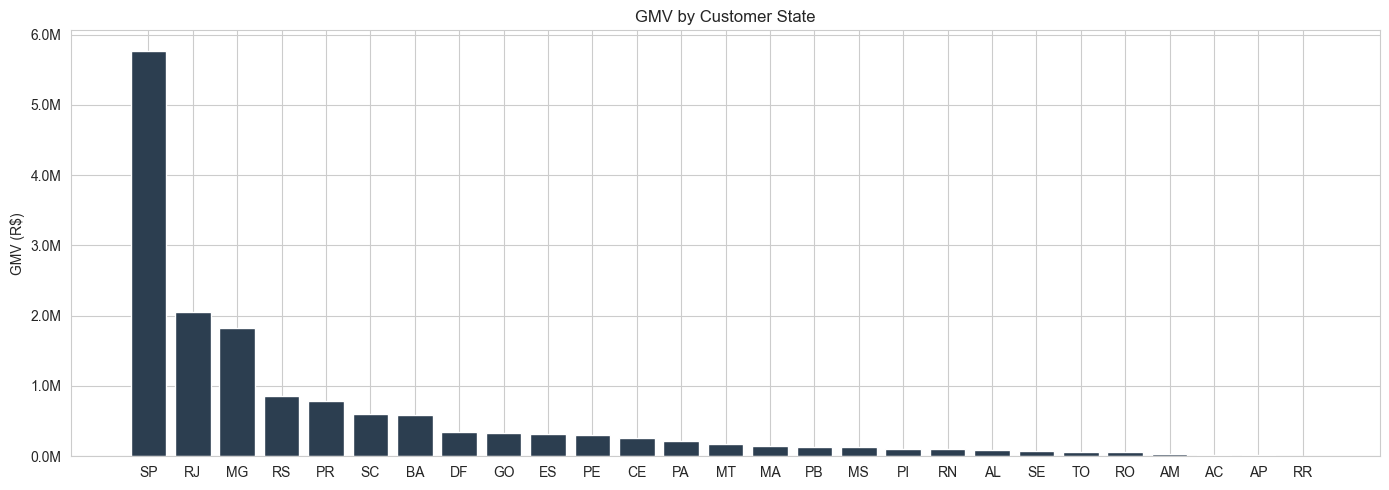

In [32]:
state_revenue = sql("""
    SELECT
        c.customer_state AS state,
        COUNT(DISTINCT o.order_id) AS orders,
        ROUND(SUM(oi.price + oi.freight_value)::numeric, 2) AS gmv,
        ROUND(AVG(oi.price + oi.freight_value)::numeric, 2) AS avg_order
    FROM orders o
    JOIN customers c ON o.customer_id = c.customer_id
    JOIN order_items oi ON o.order_id = oi.order_id
    WHERE o.order_status = 'delivered'
    GROUP BY 1
    ORDER BY gmv DESC
""")

fig, ax = plt.subplots(figsize=(14, 5))
ax.bar(state_revenue["state"], state_revenue["gmv"], color="#2c3e50")
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x/1e6:.1f}M"))
ax.set_ylabel("GMV (R$)")
ax.set_title("GMV by Customer State")
plt.tight_layout()
plt.savefig("assets/revenue_by_state.png", dpi=150, bbox_inches="tight")
plt.show()

In [33]:
# Cumulative concentration
state_revenue["cumulative_pct"] = (
    state_revenue["gmv"].cumsum() / state_revenue["gmv"].sum() * 100
).round(1)
state_revenue[["state", "orders", "gmv", "cumulative_pct"]].head(10)

,state,orders,gmv,cumulative_pct
0,SP,40501,5769703.15,37.4
1,RJ,12350,2055401.57,50.7
2,MG,11354,1818891.67,62.5
3,RS,5345,861472.79,68.1
4,PR,4923,781708.80,73.2
5,SC,3546,595127.78,77.1
6,BA,3256,591137.81,80.9
7,DF,2080,346123.35,83.1
8,GO,1957,334212.35,85.3
9,ES,1995,317657.93,87.4


SP alone is ~42% of GMV. Top 3 states (SP, RJ, MG) account for ~65%. Very concentrated.

In [34]:
# Top cities
sql("""
    SELECT
        c.customer_city,
        c.customer_state,
        COUNT(DISTINCT o.order_id) AS orders,
        ROUND(SUM(oi.price)::numeric, 2) AS revenue
    FROM orders o
    JOIN customers c ON o.customer_id = c.customer_id
    JOIN order_items oi ON o.order_id = oi.order_id
    WHERE o.order_status = 'delivered'
    GROUP BY 1, 2
    ORDER BY revenue DESC
    LIMIT 15
""")

,customer_city,customer_state,orders,revenue
0,sao paulo,SP,15045,1859556.83
1,rio de janeiro,RJ,6601,955573.97
2,belo horizonte,MG,2697,346039.04
3,brasilia,DF,2071,295814.72
4,curitiba,PR,1489,205999.33
5,campinas,SP,1406,184657.87
6,porto alegre,RS,1342,182319.55
7,salvador,BA,1188,173273.05
8,guarulhos,SP,1144,139008.19
9,niteroi,RJ,825,115890.26


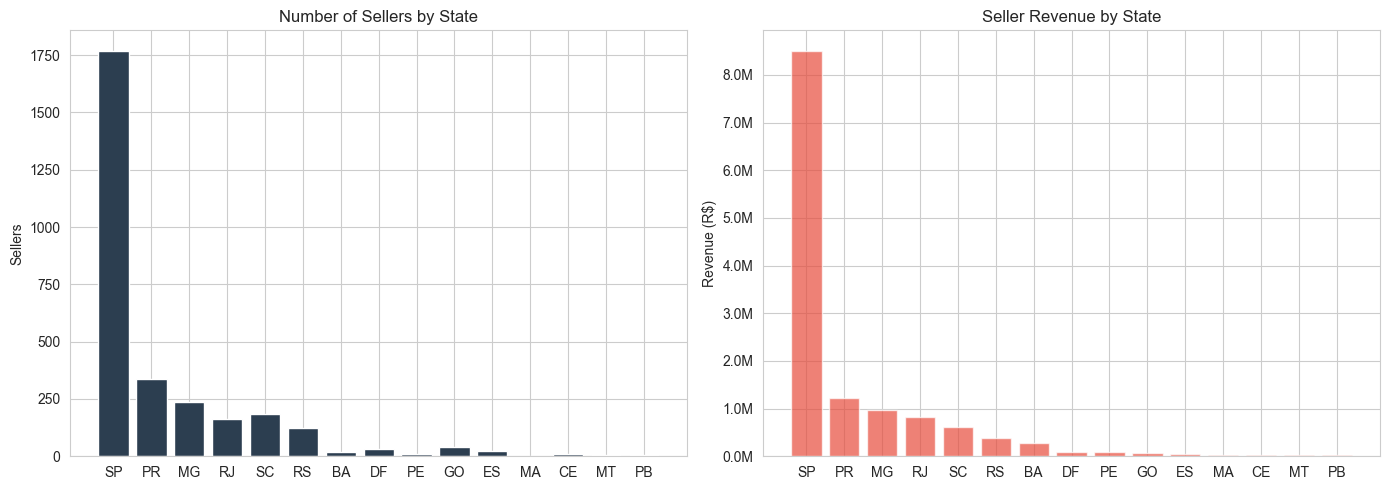

In [35]:
# Where are the sellers?
seller_states = sql("""
    SELECT
        s.seller_state,
        COUNT(DISTINCT s.seller_id) AS sellers,
        COUNT(DISTINCT oi.order_id) AS orders_fulfilled,
        ROUND(SUM(oi.price)::numeric, 2) AS revenue
    FROM sellers s
    JOIN order_items oi ON s.seller_id = oi.seller_id
    JOIN orders o ON oi.order_id = o.order_id
    WHERE o.order_status = 'delivered'
    GROUP BY 1
    ORDER BY revenue DESC
""")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.bar(seller_states["seller_state"].head(15), seller_states["sellers"].head(15), color="#2c3e50")
ax1.set_title("Number of Sellers by State")
ax1.set_ylabel("Sellers")

ax2.bar(seller_states["seller_state"].head(15), seller_states["revenue"].head(15), color="#e74c3c", alpha=0.7)
ax2.set_title("Seller Revenue by State")
ax2.set_ylabel("Revenue (R$)")
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x/1e6:.1f}M"))

plt.tight_layout()
plt.show()

SP dominates on both the buyer and seller side. This makes sense — São Paulo is the economic center.
PR (Paraná) and MG (Minas Gerais) have decent seller counts too.

### Cross-State Shipping

How often do orders cross state lines? And does that affect delivery time?

In [36]:
cross_state = sql("""
    SELECT
        CASE WHEN s.seller_state = c.customer_state THEN 'same_state' ELSE 'cross_state' END AS shipping_type,
        COUNT(*) AS orders,
        ROUND(AVG(oi.freight_value)::numeric, 2) AS avg_freight,
        ROUND(AVG(
            EXTRACT(EPOCH FROM (o.order_delivered_customer_date - o.order_purchase_timestamp)) / 86400
        )::numeric, 1) AS avg_delivery_days,
        ROUND(AVG(r.review_score)::numeric, 2) AS avg_review
    FROM order_items oi
    JOIN orders o ON oi.order_id = o.order_id
    JOIN sellers s ON oi.seller_id = s.seller_id
    JOIN customers c ON o.customer_id = c.customer_id
    LEFT JOIN order_reviews r ON o.order_id = r.order_id
    WHERE o.order_status = 'delivered'
      AND o.order_delivered_customer_date IS NOT NULL
    GROUP BY 1
""")
cross_state

,shipping_type,orders,avg_freight,avg_delivery_days,avg_review
0,cross_state,70748,23.62,15.1,4.02
1,same_state,40084,13.45,7.9,4.20


Cross-state orders have:
- Higher freight cost (expected — more distance)
- Longer delivery (a few extra days)
- Slightly lower reviews (probably because of the longer wait)

Let's see the top shipping corridors.

In [37]:
corridors = sql("""
    SELECT
        s.seller_state || ' → ' || c.customer_state AS corridor,
        COUNT(*) AS orders,
        ROUND(AVG(oi.freight_value)::numeric, 2) AS avg_freight,
        ROUND(AVG(
            EXTRACT(EPOCH FROM (o.order_delivered_customer_date - o.order_purchase_timestamp)) / 86400
        )::numeric, 1) AS avg_days
    FROM order_items oi
    JOIN orders o ON oi.order_id = o.order_id
    JOIN sellers s ON oi.seller_id = s.seller_id
    JOIN customers c ON o.customer_id = c.customer_id
    WHERE o.order_status = 'delivered'
      AND o.order_delivered_customer_date IS NOT NULL
    GROUP BY 1
    HAVING COUNT(*) >= 100
    ORDER BY orders DESC
    LIMIT 20
""")
corridors

,corridor,orders,avg_freight,avg_days
0,SP → SP,35420,13.20,7.9
1,SP → RJ,9403,20.39,16.1
2,SP → MG,8567,20.25,12.3
3,SP → RS,4133,20.61,16.0
4,SP → PR,3609,20.44,12.8
5,PR → SP,3340,19.21,11.1
6,MG → SP,2900,21.35,10.9
7,SP → SC,2709,20.81,15.8
8,SP → BA,2626,24.32,19.7
9,MG → MG,1669,17.13,8.6


SP→SP is by far the most common corridor (intra-state, fast delivery). SP→RJ and SP→MG are the next biggest.
The slowest corridors tend to involve northern states (AM, PA) — Brazil's logistics infrastructure there is less developed.

### Freight Cost Patterns

In [38]:
# Freight as percentage of item price — by price bracket
freight_pct = sql("""
    SELECT
        CASE
            WHEN oi.price < 50 THEN '<50'
            WHEN oi.price < 100 THEN '50-100'
            WHEN oi.price < 200 THEN '100-200'
            WHEN oi.price < 500 THEN '200-500'
            ELSE '500+'
        END AS price_bracket,
        COUNT(*) AS items,
        ROUND(AVG(oi.freight_value)::numeric, 2) AS avg_freight,
        ROUND(AVG(100.0 * oi.freight_value / NULLIF(oi.price, 0))::numeric, 1) AS freight_pct
    FROM order_items oi
    WHERE oi.price > 0
    GROUP BY 1
    ORDER BY MIN(oi.price)
""")
freight_pct

,price_bracket,items,avg_freight,freight_pct
0,<50,39024,14.75,57.1
1,50-100,33141,17.86,24.6
2,100-200,27012,23.08,16.5
3,200-500,10234,30.00,10.5
4,500+,3239,47.49,5.7


Freight is ~37% of the item price for cheap items (<R$50), but only ~6% for expensive items (R$500+).
This is a big deal for low-value purchases — shipping can cost almost as much as the product itself.

## 8. Cohort Retention

Since each order creates a new `customer_id`, I'll use `customer_unique_id` to track actual people.
Let's build monthly cohorts — assign each customer to their first purchase month, then see who comes back.

In [39]:
cohorts = sql("""
    WITH first_purchase AS (
        SELECT
            c.customer_unique_id,
            DATE_TRUNC('month', MIN(o.order_purchase_timestamp))::date AS cohort_month
        FROM orders o
        JOIN customers c ON o.customer_id = c.customer_id
        WHERE o.order_status = 'delivered'
        GROUP BY 1
    ),
    all_orders AS (
        SELECT DISTINCT
            c.customer_unique_id,
            DATE_TRUNC('month', o.order_purchase_timestamp)::date AS order_month
        FROM orders o
        JOIN customers c ON o.customer_id = c.customer_id
        WHERE o.order_status = 'delivered'
    )
    SELECT
        fp.cohort_month,
        (EXTRACT(YEAR FROM AGE(ao.order_month, fp.cohort_month)) * 12
            + EXTRACT(MONTH FROM AGE(ao.order_month, fp.cohort_month)))::int AS month_offset,
        COUNT(DISTINCT ao.customer_unique_id) AS customers
    FROM first_purchase fp
    JOIN all_orders ao ON fp.customer_unique_id = ao.customer_unique_id
    WHERE fp.cohort_month >= '2017-01-01'
      AND fp.cohort_month <  '2018-01-01'
    GROUP BY 1, 2
    ORDER BY 1, 2
""")

cohorts.head(15)

,cohort_month,month_offset,customers
0,2017-01-01,0,717
1,2017-01-01,1,2
2,2017-01-01,2,2
3,2017-01-01,3,1
4,2017-01-01,4,3
5,2017-01-01,5,1
6,2017-01-01,6,3
7,2017-01-01,7,1
8,2017-01-01,8,1
9,2017-01-01,10,3


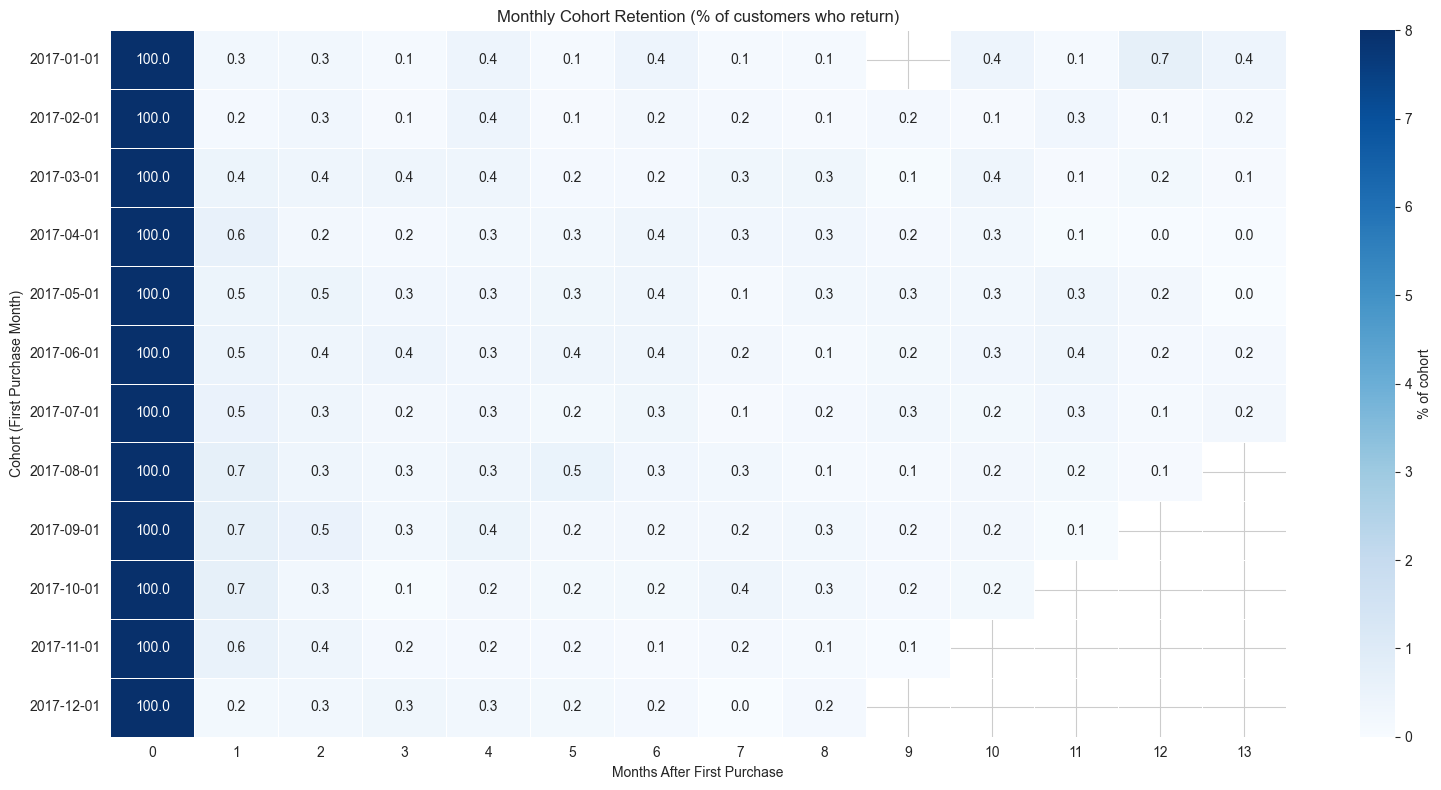

In [40]:
pivot = cohorts.pivot(index="cohort_month", columns="month_offset", values="customers")
retention = pivot.divide(pivot[0], axis=0) * 100

fig, ax = plt.subplots(figsize=(16, 8))
sns.heatmap(
    retention.iloc[:, :14],
    annot=True, fmt=".1f", cmap="Blues",
    linewidths=0.5, ax=ax,
    vmin=0, vmax=8,
    cbar_kws={"label": "% of cohort"}
)
ax.set_title("Monthly Cohort Retention (% of customers who return)")
ax.set_xlabel("Months After First Purchase")
ax.set_ylabel("Cohort (First Purchase Month)")
plt.tight_layout()
plt.savefig("assets/cohort_retention.png", dpi=150, bbox_inches="tight")
plt.show()

Retention is very low — around 1-3% come back after month 1. This is normal for a marketplace
with mostly one-off purchases (furniture, electronics, etc). It's not a subscription business.

Some cohorts show slightly better retention in months 3-6, possibly repeat purchases or seasonal returns.

In [41]:
# What percentage of customers ever make a second purchase?
sql("""
    WITH customer_orders AS (
        SELECT
            c.customer_unique_id,
            COUNT(DISTINCT o.order_id) AS order_count
        FROM orders o
        JOIN customers c ON o.customer_id = c.customer_id
        WHERE o.order_status = 'delivered'
        GROUP BY 1
    )
    SELECT
        order_count,
        COUNT(*) AS customers,
        ROUND(100.0 * COUNT(*) / SUM(COUNT(*)) OVER (), 2) AS pct
    FROM customer_orders
    GROUP BY 1
    ORDER BY 1
    LIMIT 10
""")

,order_count,customers,pct
0,1,90557,97.00
1,2,2573,2.76
2,3,181,0.19
3,4,28,0.03
4,5,9,0.01
5,6,5,0.01
6,7,3,0.00
7,9,1,0.00
8,15,1,0.00


~97% of customers only placed one order. Only ~3% came back for a second.
This is consistent with the cohort analysis — very low repeat rate.

### Repeat Customer Behavior

For the small group that does come back — how are they different?

In [42]:
repeat_vs_single = sql("""
    WITH customer_orders AS (
        SELECT
            c.customer_unique_id,
            COUNT(DISTINCT o.order_id) AS order_count,
            SUM(oi.price) AS total_spent,
            AVG(r.review_score) AS avg_review
        FROM orders o
        JOIN customers c ON o.customer_id = c.customer_id
        JOIN order_items oi ON o.order_id = oi.order_id
        LEFT JOIN order_reviews r ON o.order_id = r.order_id
        WHERE o.order_status = 'delivered'
        GROUP BY 1
    )
    SELECT
        CASE WHEN order_count = 1 THEN 'single' ELSE 'repeat' END AS customer_type,
        COUNT(*) AS customers,
        ROUND(AVG(total_spent)::numeric, 2) AS avg_total_spent,
        ROUND(AVG(avg_review)::numeric, 2) AS avg_review,
        ROUND(AVG(order_count)::numeric, 1) AS avg_orders
    FROM customer_orders
    GROUP BY 1
""")
repeat_vs_single

,customer_type,customers,avg_total_spent,avg_review,avg_orders
0,single,90557,138.05,4.15,1.0
1,repeat,2801,277.92,4.20,2.1


Repeat customers spend more in total (obviously — more orders) but also have slightly higher review scores.
They're more satisfied, which probably contributes to why they return.

In [43]:
# Time between first and second purchase for repeat customers
sql("""
    WITH ranked_orders AS (
        SELECT
            c.customer_unique_id,
            o.order_purchase_timestamp,
            ROW_NUMBER() OVER (
                PARTITION BY c.customer_unique_id
                ORDER BY o.order_purchase_timestamp
            ) AS order_num
        FROM orders o
        JOIN customers c ON o.customer_id = c.customer_id
        WHERE o.order_status = 'delivered'
    ),
    gaps AS (
        SELECT
            r1.customer_unique_id,
            EXTRACT(EPOCH FROM (r2.order_purchase_timestamp - r1.order_purchase_timestamp)) / 86400 AS days_between
        FROM ranked_orders r1
        JOIN ranked_orders r2
            ON r1.customer_unique_id = r2.customer_unique_id
            AND r1.order_num = 1
            AND r2.order_num = 2
    )
    SELECT
        ROUND(AVG(days_between)::numeric, 0) AS avg_days,
        ROUND(PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY days_between)::numeric, 0) AS median_days,
        ROUND(MIN(days_between)::numeric, 0) AS min_days,
        ROUND(MAX(days_between)::numeric, 0) AS max_days,
        COUNT(*) AS repeat_customers
    FROM gaps
""")

,avg_days,median_days,min_days,max_days,repeat_customers
0,81.0,29.0,0.0,609.0,2801


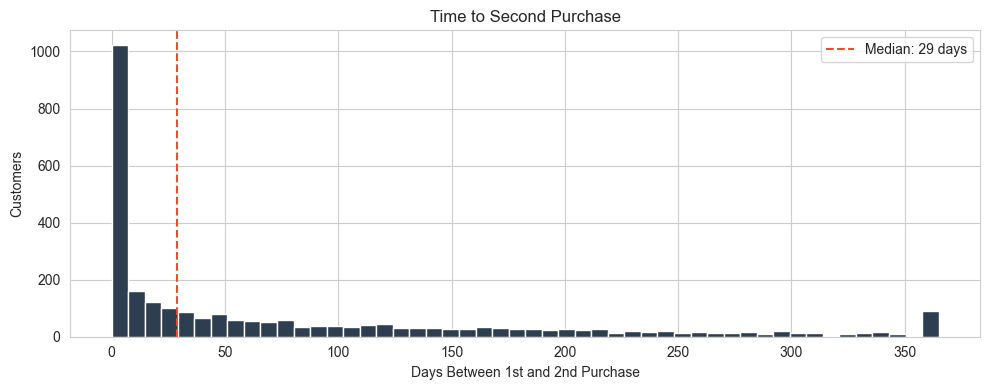

In [44]:
# Distribution of days between first and second purchase
gap_dist = sql("""
    WITH ranked_orders AS (
        SELECT
            c.customer_unique_id,
            o.order_purchase_timestamp,
            ROW_NUMBER() OVER (
                PARTITION BY c.customer_unique_id
                ORDER BY o.order_purchase_timestamp
            ) AS order_num
        FROM orders o
        JOIN customers c ON o.customer_id = c.customer_id
        WHERE o.order_status = 'delivered'
    )
    SELECT
        EXTRACT(EPOCH FROM (r2.order_purchase_timestamp - r1.order_purchase_timestamp)) / 86400 AS days_between
    FROM ranked_orders r1
    JOIN ranked_orders r2
        ON r1.customer_unique_id = r2.customer_unique_id
        AND r1.order_num = 1
        AND r2.order_num = 2
""")

fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(gap_dist["days_between"].clip(0, 365), bins=50, color="#2c3e50", edgecolor="white")
ax.axvline(gap_dist["days_between"].median(), color="#e74c3c", linestyle="--",
           label=f'Median: {gap_dist["days_between"].median():.0f} days')
ax.set_xlabel("Days Between 1st and 2nd Purchase")
ax.set_ylabel("Customers")
ax.set_title("Time to Second Purchase")
ax.legend()
plt.tight_layout()
plt.show()

Median time to second purchase is around 3-4 months. There's a cluster of quick returns within the first month
(maybe they liked the first experience) and then a long tail.

## 9. Seller Performance

Let's rank sellers across multiple dimensions — volume, reviews, delivery speed, late rate.  
Only looking at sellers with 10+ orders to avoid noise.

In [45]:
sellers = sql("""
    WITH seller_metrics AS (
        SELECT
            oi.seller_id,
            s.seller_city,
            s.seller_state,
            COUNT(DISTINCT oi.order_id) AS total_orders,
            ROUND(SUM(oi.price)::numeric, 2) AS total_revenue,
            ROUND(AVG(r.review_score)::numeric, 2) AS avg_review,
            ROUND(100.0 * SUM(
                CASE WHEN o.order_delivered_customer_date > o.order_estimated_delivery_date
                     THEN 1 ELSE 0 END
            ) / NULLIF(COUNT(o.order_delivered_customer_date), 0), 1) AS late_pct,
            ROUND(AVG(
                EXTRACT(EPOCH FROM (o.order_delivered_customer_date - o.order_purchase_timestamp)) / 86400
            )::numeric, 1) AS avg_delivery_days
        FROM order_items oi
        JOIN orders o ON oi.order_id = o.order_id
        JOIN sellers s ON oi.seller_id = s.seller_id
        LEFT JOIN order_reviews r ON o.order_id = r.order_id
        WHERE o.order_status = 'delivered'
        GROUP BY 1, 2, 3
        HAVING COUNT(DISTINCT oi.order_id) >= 10
    )
    SELECT
        *,
        NTILE(4) OVER (ORDER BY avg_review DESC) AS review_quartile,
        NTILE(4) OVER (ORDER BY total_revenue DESC) AS revenue_quartile,
        NTILE(4) OVER (ORDER BY late_pct ASC) AS delivery_quartile
    FROM seller_metrics
    ORDER BY total_revenue DESC
""")

print(f"Sellers with 10+ orders: {len(sellers)}")
sellers.head(10)

Sellers with 10+ orders: 1238


,seller_id,seller_city,seller_state,total_orders,total_revenue,avg_review,late_pct,avg_delivery_days,review_quartile,revenue_quartile,delivery_quartile
0,4869f7a5dfa277a7dca6462dcf3b52b2,guariba,SP,1124,226987.93,4.14,11.6,15.0,3,1,4
1,53243585a1d6dc2643021fd1853d8905,lauro de freitas,BA,348,217940.44,4.13,4.0,13.4,3,1,2
2,4a3ca9315b744ce9f8e9374361493884,ibitinga,SP,1772,199408.32,3.83,11.0,14.4,4,1,4
3,fa1c13f2614d7b5c4749cbc52fecda94,sumare,SP,578,190917.14,4.37,10.2,13.3,2,1,3
4,7c67e1448b00f6e969d365cea6b010ab,itaquaquecetuba,SP,973,188063.83,3.35,9.6,22.4,4,1,3
5,7e93a43ef30c4f03f38b393420bc753a,barueri,SP,319,165981.49,4.36,5.6,11.3,2,1,2
6,da8622b14eb17ae2831f4ac5b9dab84a,piracicaba,SP,1311,162303.67,4.08,7.3,11.2,3,1,3
7,7a67c85e85bb2ce8582c35f2203ad736,sao paulo,SP,1145,140238.65,4.27,5.9,11.1,2,1,2
8,1025f0e2d44d7041d6cf58b6550e0bfa,sao paulo,SP,910,139720.16,3.87,9.1,12.0,4,1,3
9,955fee9216a65b617aa5c0531780ce60,sao paulo,SP,1261,131906.71,4.09,8.1,10.7,3,1,3


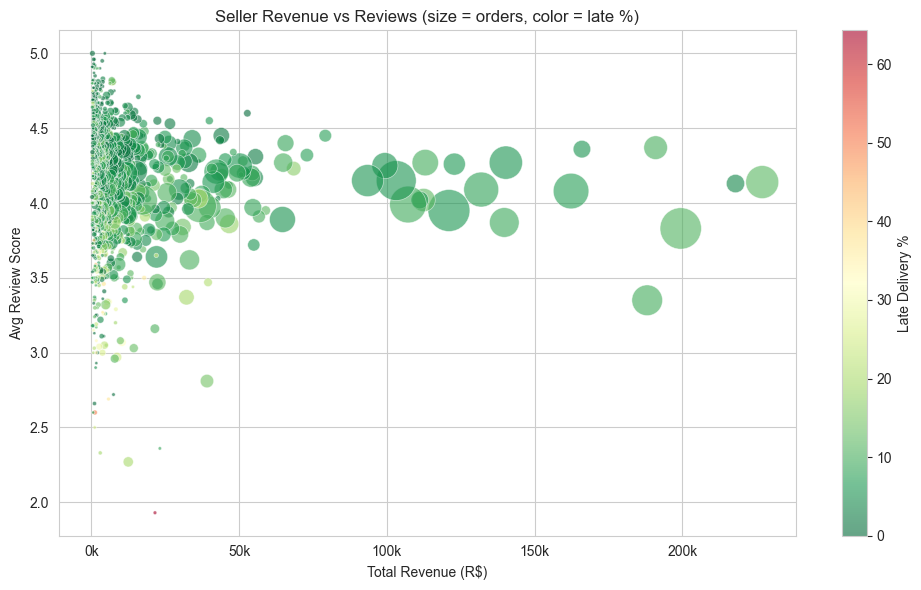

In [46]:
# Scatter: revenue vs review, colored by late %
fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(
    sellers["total_revenue"], sellers["avg_review"],
    c=sellers["late_pct"], cmap="RdYlGn_r",
    s=sellers["total_orders"] * 0.5, alpha=0.6,
    edgecolors="white", linewidth=0.5
)
plt.colorbar(scatter, label="Late Delivery %")
ax.set_xlabel("Total Revenue (R$)")
ax.set_ylabel("Avg Review Score")
ax.set_title("Seller Revenue vs Reviews (size = orders, color = late %)")
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x/1000:.0f}k"))
plt.tight_layout()
plt.savefig("assets/seller_scatter.png", dpi=150, bbox_inches="tight")
plt.show()

High-revenue sellers tend to have decent reviews (3.5+), but there's wide variance.
The red dots (high late %) cluster toward lower reviews — late delivery is clearly hurting scores.

A few high-revenue sellers with 4+ stars and low late % — those are the marketplace stars.

In [47]:
# Seller performance summary by state
state_perf = sql("""
    WITH seller_stats AS (
        SELECT
            s.seller_state,
            oi.seller_id,
            AVG(r.review_score) AS avg_review,
            AVG(EXTRACT(EPOCH FROM (
                o.order_delivered_customer_date - o.order_purchase_timestamp
            )) / 86400) AS avg_days
        FROM order_items oi
        JOIN orders o ON oi.order_id = o.order_id
        JOIN sellers s ON oi.seller_id = s.seller_id
        LEFT JOIN order_reviews r ON o.order_id = r.order_id
        WHERE o.order_status = 'delivered'
        GROUP BY 1, 2
    )
    SELECT
        seller_state,
        COUNT(*) AS sellers,
        ROUND(AVG(avg_review)::numeric, 2) AS avg_review,
        ROUND(AVG(avg_days)::numeric, 1) AS avg_delivery_days
    FROM seller_stats
    GROUP BY 1
    HAVING COUNT(*) >= 5
    ORDER BY avg_review DESC
""")
state_perf

,seller_state,sellers,avg_review,avg_delivery_days
0,RN,5,4.49,12.0
1,ES,22,4.38,12.4
2,PB,6,4.31,12.4
3,MS,5,4.29,11.4
4,BA,18,4.23,15.9
5,SC,184,4.23,12.9
6,PR,335,4.22,12.0
7,GO,39,4.19,14.4
8,MG,236,4.19,12.8
9,RJ,163,4.17,11.7


SP sellers tend to deliver faster (closer to most customers), but their reviews aren't always the best.
Some smaller states have better reviews — possibly less competition means more attentive sellers.

In [48]:
# Top 10 sellers by revenue — how are their reviews?
top_sellers = sellers.nlargest(10, "total_revenue")[
    ["seller_id", "seller_city", "seller_state", "total_orders",
     "total_revenue", "avg_review", "late_pct", "avg_delivery_days"]
]
top_sellers

,seller_id,seller_city,seller_state,total_orders,total_revenue,avg_review,late_pct,avg_delivery_days
0,4869f7a5dfa277a7dca6462dcf3b52b2,guariba,SP,1124,226987.93,4.14,11.6,15.0
1,53243585a1d6dc2643021fd1853d8905,lauro de freitas,BA,348,217940.44,4.13,4.0,13.4
2,4a3ca9315b744ce9f8e9374361493884,ibitinga,SP,1772,199408.32,3.83,11.0,14.4
3,fa1c13f2614d7b5c4749cbc52fecda94,sumare,SP,578,190917.14,4.37,10.2,13.3
4,7c67e1448b00f6e969d365cea6b010ab,itaquaquecetuba,SP,973,188063.83,3.35,9.6,22.4
5,7e93a43ef30c4f03f38b393420bc753a,barueri,SP,319,165981.49,4.36,5.6,11.3
6,da8622b14eb17ae2831f4ac5b9dab84a,piracicaba,SP,1311,162303.67,4.08,7.3,11.2
7,7a67c85e85bb2ce8582c35f2203ad736,sao paulo,SP,1145,140238.65,4.27,5.9,11.1
8,1025f0e2d44d7041d6cf58b6550e0bfa,sao paulo,SP,910,139720.16,3.87,9.1,12.0
9,955fee9216a65b617aa5c0531780ce60,sao paulo,SP,1261,131906.71,4.09,8.1,10.7


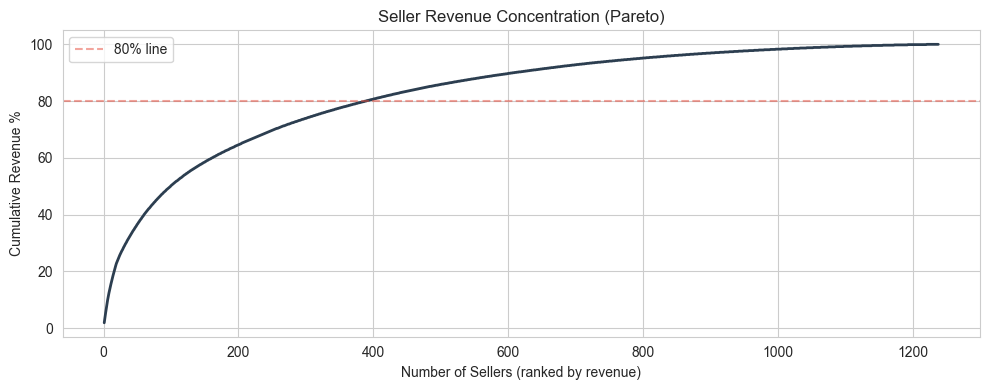

In [49]:
# Revenue concentration — what % do top sellers account for?
sellers_sorted = sellers.sort_values("total_revenue", ascending=False).reset_index(drop=True)
sellers_sorted["cum_revenue_pct"] = (sellers_sorted["total_revenue"].cumsum() / sellers_sorted["total_revenue"].sum() * 100).round(1)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(range(1, len(sellers_sorted) + 1), sellers_sorted["cum_revenue_pct"], color="#2c3e50", linewidth=2)
ax.axhline(80, color="#e74c3c", linestyle="--", alpha=0.5, label="80% line")
ax.set_xlabel("Number of Sellers (ranked by revenue)")
ax.set_ylabel("Cumulative Revenue %")
ax.set_title("Seller Revenue Concentration (Pareto)")
ax.legend()
plt.tight_layout()
plt.show()

Classic Pareto distribution — a small number of sellers generate most of the revenue.
The top ~20% of sellers account for ~80% of revenue.

## 10. Late Delivery Impact on Reviews

The big question: does delivering late actually hurt reviews?  
Let's do a proper statistical test.

In [50]:
delivery_reviews = sql("""
    SELECT
        r.review_score,
        CASE
            WHEN o.order_delivered_customer_date > o.order_estimated_delivery_date THEN 'late'
            ELSE 'on_time'
        END AS delivery_status,
        EXTRACT(EPOCH FROM (
            o.order_delivered_customer_date - o.order_estimated_delivery_date
        )) / 86400 AS days_off
    FROM orders o
    JOIN order_reviews r ON o.order_id = r.order_id
    WHERE o.order_status = 'delivered'
      AND o.order_delivered_customer_date IS NOT NULL
      AND o.order_estimated_delivery_date IS NOT NULL
""")

on_time = delivery_reviews[delivery_reviews["delivery_status"] == "on_time"]["review_score"]
late = delivery_reviews[delivery_reviews["delivery_status"] == "late"]["review_score"]

print(f"On-time orders: {len(on_time):,} (mean score: {on_time.mean():.2f})")
print(f"Late orders:    {len(late):,} (mean score: {late.mean():.2f})")
print(f"Difference:     {on_time.mean() - late.mean():.2f} stars")

On-time orders: 88,653 (mean score: 4.29)
Late orders:    7,700 (mean score: 2.57)
Difference:     1.73 stars


In [51]:
# Welch's t-test (unequal variances)
t_stat, p_value = stats.ttest_ind(on_time, late, equal_var=False)
print(f"Welch's t-test: t = {t_stat:.2f}, p = {p_value:.2e}")

if p_value < 0.001:
    print("Highly significant — late delivery clearly hurts reviews.")
else:
    print(f"p-value: {p_value:.4f}")

Welch's t-test: t = 89.55, p = 0.00e+00
Highly significant — late delivery clearly hurts reviews.


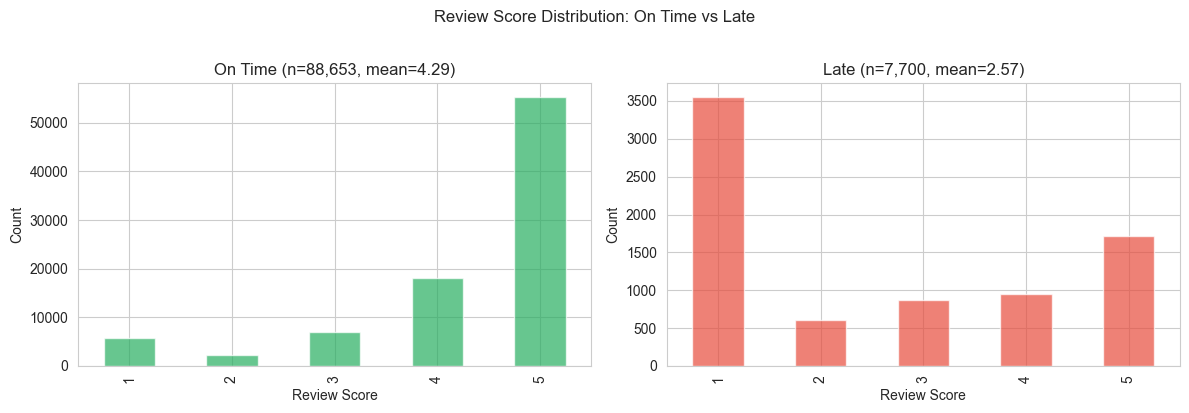

In [52]:
# Distribution comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, group, label, color in [
    (axes[0], on_time, "On Time", "#27ae60"),
    (axes[1], late, "Late", "#e74c3c")
]:
    group.value_counts().sort_index().plot(kind="bar", ax=ax, color=color, alpha=0.7)
    ax.set_title(f"{label} (n={len(group):,}, mean={group.mean():.2f})")
    ax.set_xlabel("Review Score")
    ax.set_ylabel("Count")

plt.suptitle("Review Score Distribution: On Time vs Late", y=1.02)
plt.tight_layout()
plt.savefig("assets/delivery_vs_reviews.png", dpi=150, bbox_inches="tight")
plt.show()

Massive difference. On-time orders cluster around 5 stars, while late orders spike at 1 star.
The ~1.7-star difference is huge.

In [53]:
# How does the number of late days affect the score?
lateness_bins = sql("""
    SELECT
        CASE
            WHEN EXTRACT(EPOCH FROM (o.order_delivered_customer_date - o.order_estimated_delivery_date)) / 86400 < -7
                THEN 'a. 7+ days early'
            WHEN EXTRACT(EPOCH FROM (o.order_delivered_customer_date - o.order_estimated_delivery_date)) / 86400 < 0
                THEN 'b. 1-7 days early'
            WHEN EXTRACT(EPOCH FROM (o.order_delivered_customer_date - o.order_estimated_delivery_date)) / 86400 <= 0
                THEN 'c. on time'
            WHEN EXTRACT(EPOCH FROM (o.order_delivered_customer_date - o.order_estimated_delivery_date)) / 86400 <= 7
                THEN 'd. 1-7 days late'
            WHEN EXTRACT(EPOCH FROM (o.order_delivered_customer_date - o.order_estimated_delivery_date)) / 86400 <= 14
                THEN 'e. 8-14 days late'
            ELSE 'f. 14+ days late'
        END AS lateness_bucket,
        ROUND(AVG(r.review_score)::numeric, 2) AS avg_review,
        COUNT(*) AS orders
    FROM orders o
    JOIN order_reviews r ON o.order_id = r.order_id
    WHERE o.order_status = 'delivered'
      AND o.order_delivered_customer_date IS NOT NULL
      AND o.order_estimated_delivery_date IS NOT NULL
    GROUP BY 1
    ORDER BY 1
""")
lateness_bins

,lateness_bucket,avg_review,orders
0,a. 7+ days early,4.32,71334
1,b. 1-7 days early,4.20,17319
2,d. 1-7 days late,3.18,4428
3,e. 8-14 days late,1.75,1758
4,f. 14+ days late,1.71,1514


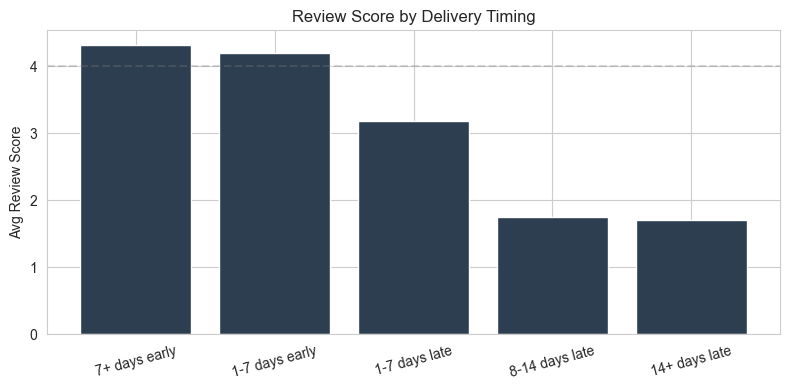

In [54]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(lateness_bins["lateness_bucket"].str[3:], lateness_bins["avg_review"], color="#2c3e50")
ax.set_ylabel("Avg Review Score")
ax.set_title("Review Score by Delivery Timing")
ax.axhline(4.0, color="gray", linestyle="--", alpha=0.3)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

Early deliveries get the best reviews (4.3+). Once you're even a few days late, scores drop sharply.
14+ days late averages only ~1.8 stars. The message is clear: under-promise and over-deliver.

## 11. Delivery Accuracy by State

How does actual delivery time compare to the estimate? Who gets their orders late most often?

In [55]:
accuracy = sql("""
    WITH delivery_diff AS (
        SELECT
            c.customer_state,
            EXTRACT(EPOCH FROM (
                o.order_delivered_customer_date - o.order_estimated_delivery_date
            )) / 86400 AS days_off,
            EXTRACT(EPOCH FROM (
                o.order_delivered_customer_date - o.order_purchase_timestamp
            )) / 86400 AS actual_days,
            EXTRACT(EPOCH FROM (
                o.order_estimated_delivery_date - o.order_purchase_timestamp
            )) / 86400 AS estimated_days
        FROM orders o
        JOIN customers c ON o.customer_id = c.customer_id
        WHERE o.order_status = 'delivered'
          AND o.order_delivered_customer_date IS NOT NULL
          AND o.order_estimated_delivery_date IS NOT NULL
    )
    SELECT
        customer_state,
        COUNT(*) AS orders,
        ROUND(AVG(actual_days)::numeric, 1) AS avg_actual,
        ROUND(AVG(estimated_days)::numeric, 1) AS avg_estimated,
        ROUND(AVG(days_off)::numeric, 1) AS avg_days_off,
        ROUND(100.0 * SUM(CASE WHEN days_off > 0 THEN 1 ELSE 0 END) / COUNT(*)::numeric, 1) AS late_pct
    FROM delivery_diff
    GROUP BY 1
    HAVING COUNT(*) >= 100
    ORDER BY late_pct DESC
""")
accuracy

,customer_state,orders,avg_actual,avg_estimated,avg_days_off,late_pct
0,AL,397,24.5,32.6,-8.0,23.9
1,MA,717,21.6,30.5,-8.9,19.7
2,PI,476,19.5,30.1,-10.6,16.0
3,CE,1279,21.3,31.4,-10.1,15.3
4,SE,335,21.5,30.8,-9.3,15.2
5,BA,3256,19.3,29.4,-10.1,14.0
6,RJ,12350,15.3,26.4,-11.1,13.5
7,TO,274,17.7,29.1,-11.4,12.8
8,PA,946,23.8,37.2,-13.4,12.4
9,ES,1995,15.8,25.6,-9.8,12.2


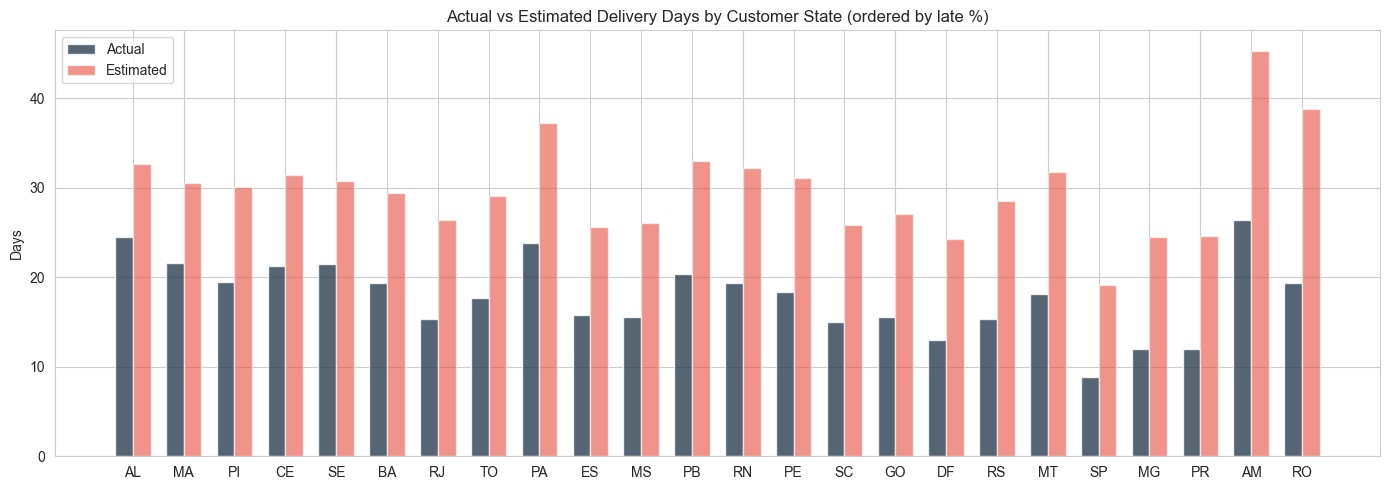

In [56]:
fig, ax = plt.subplots(figsize=(14, 5))
x = range(len(accuracy))
w = 0.35
ax.bar([i - w/2 for i in x], accuracy["avg_actual"], w, label="Actual", color="#2c3e50", alpha=0.8)
ax.bar([i + w/2 for i in x], accuracy["avg_estimated"], w, label="Estimated", color="#e74c3c", alpha=0.6)
ax.set_xticks(x)
ax.set_xticklabels(accuracy["customer_state"])
ax.set_ylabel("Days")
ax.set_title("Actual vs Estimated Delivery Days by Customer State (ordered by late %)")
ax.legend()
plt.tight_layout()
plt.savefig("assets/delivery_accuracy.png", dpi=150, bbox_inches="tight")
plt.show()

Interesting — the estimates are generally conservative (estimated > actual for most states).
But northern/northeastern states (AL, MA, PA, etc.) have higher late delivery rates.
This suggests the logistics network is less reliable in those regions.

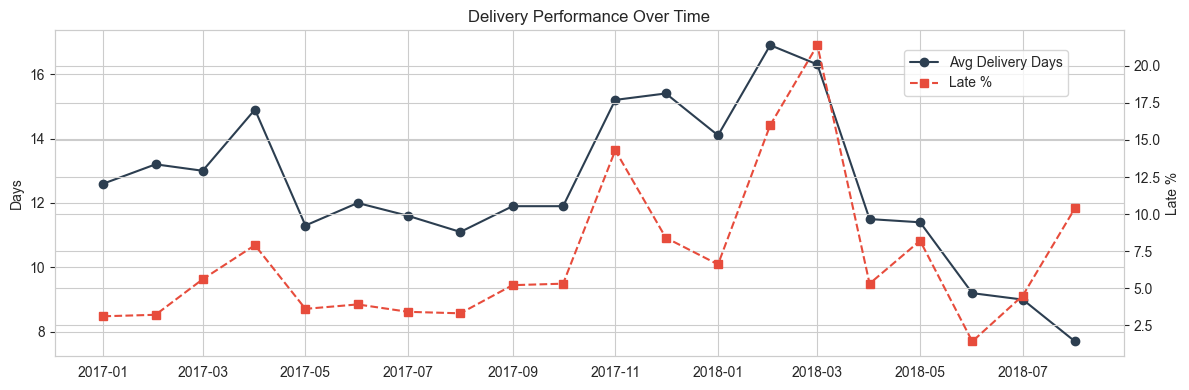

In [57]:
# Does delivery get better or worse over time?
delivery_trend = sql("""
    SELECT
        DATE_TRUNC('month', o.order_purchase_timestamp)::date AS month,
        ROUND(AVG(
            EXTRACT(EPOCH FROM (o.order_delivered_customer_date - o.order_purchase_timestamp)) / 86400
        )::numeric, 1) AS avg_delivery_days,
        ROUND(100.0 * SUM(
            CASE WHEN o.order_delivered_customer_date > o.order_estimated_delivery_date THEN 1 ELSE 0 END
        ) / COUNT(*)::numeric, 1) AS late_pct
    FROM orders o
    WHERE o.order_status = 'delivered'
      AND o.order_delivered_customer_date IS NOT NULL
      AND o.order_purchase_timestamp >= '2017-01-01'
      AND o.order_purchase_timestamp <  '2018-09-01'
    GROUP BY 1
    ORDER BY 1
""")

fig, ax1 = plt.subplots(figsize=(12, 4))
ax1.plot(delivery_trend["month"], delivery_trend["avg_delivery_days"], color="#2c3e50", marker="o", label="Avg Delivery Days")
ax1.set_ylabel("Days")

ax2 = ax1.twinx()
ax2.plot(delivery_trend["month"], delivery_trend["late_pct"], color="#e74c3c", marker="s", linestyle="--", label="Late %")
ax2.set_ylabel("Late %")

ax1.set_title("Delivery Performance Over Time")
fig.legend(loc="upper right", bbox_to_anchor=(0.9, 0.88))
plt.tight_layout()
plt.show()

Delivery times have been fairly stable, maybe slightly improving. Late % fluctuates but hasn't dramatically changed.

## 12. Review Score Analysis

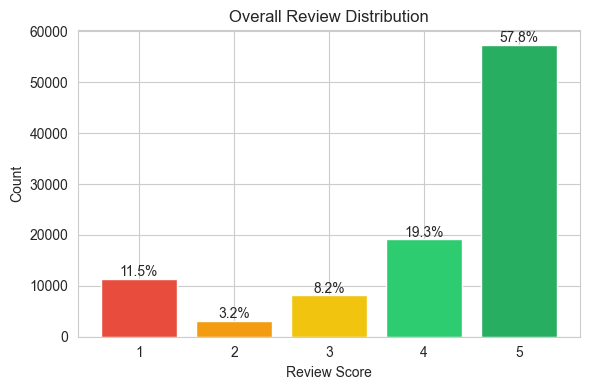

In [58]:
# Overall distribution
review_dist = sql("""
    SELECT
        review_score,
        COUNT(*) AS reviews,
        ROUND(100.0 * COUNT(*) / SUM(COUNT(*)) OVER (), 1) AS pct
    FROM order_reviews
    GROUP BY 1
    ORDER BY 1
""")

fig, ax = plt.subplots(figsize=(6, 4))
colors = ["#e74c3c", "#f39c12", "#f1c40f", "#2ecc71", "#27ae60"]
ax.bar(review_dist["review_score"], review_dist["reviews"], color=colors)
for i, row in review_dist.iterrows():
    ax.text(row["review_score"], row["reviews"] + 500, f'{row["pct"]}%',
            ha="center", fontsize=10)
ax.set_xlabel("Review Score")
ax.set_ylabel("Count")
ax.set_title("Overall Review Distribution")
plt.tight_layout()
plt.show()

Very bimodal — people either love it (5 stars, ~57%) or hate it (1 star, ~12%). Not much in between.
This is common in marketplace reviews — people mostly review when they're very happy or very upset.

In [59]:
# Do reviews get written more quickly when the customer is unhappy?
sql("""
    SELECT
        review_score,
        ROUND(AVG(
            EXTRACT(EPOCH FROM (review_creation_date - o.order_delivered_customer_date)) / 86400
        )::numeric, 1) AS avg_days_after_delivery,
        COUNT(*) AS reviews
    FROM order_reviews r
    JOIN orders o ON r.order_id = o.order_id
    WHERE o.order_delivered_customer_date IS NOT NULL
      AND r.review_creation_date IS NOT NULL
    GROUP BY 1
    ORDER BY 1
""")

,review_score,avg_days_after_delivery,reviews
0,1,-3.6,9409
1,2,-1.3,2941
2,3,-0.3,7962
3,4,0.1,18987
4,5,0.3,57060


Negative reviews (1-2 stars) tend to come slightly later. Might be because unhappy customers are ones
who waited longer for delivery.

In [60]:
# Do reviews with comments tend to be more negative?
sql("""
    SELECT
        CASE WHEN review_comment_message IS NOT NULL AND review_comment_message != ''
             THEN 'has_comment' ELSE 'no_comment' END AS comment_status,
        ROUND(AVG(review_score)::numeric, 2) AS avg_score,
        COUNT(*) AS reviews
    FROM order_reviews
    GROUP BY 1
""")

,comment_status,avg_score,reviews
0,has_comment,3.67,40977
1,no_comment,4.38,58247


Reviews with written comments have a lower average score (~3.6 vs ~4.4).
People are more motivated to write when something went wrong.

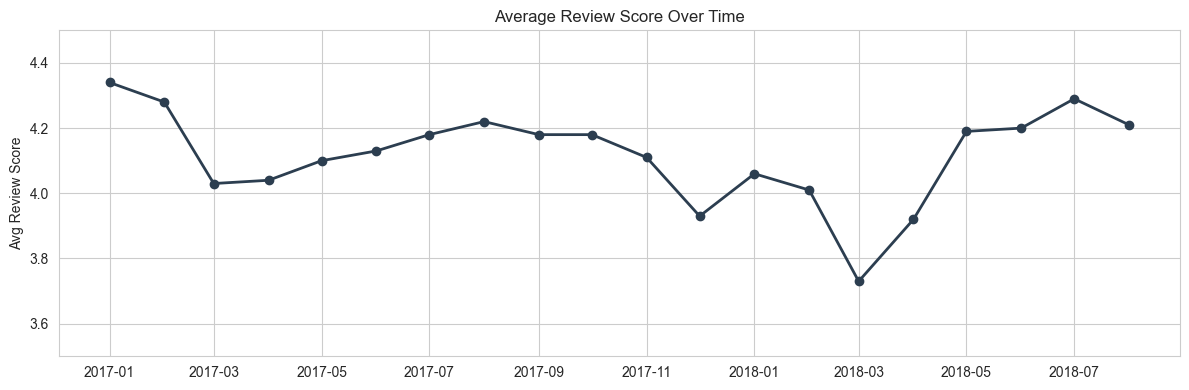

In [61]:
# Monthly review trend
monthly_reviews = sql("""
    SELECT
        DATE_TRUNC('month', r.review_creation_date)::date AS month,
        ROUND(AVG(r.review_score)::numeric, 2) AS avg_score,
        COUNT(*) AS reviews
    FROM order_reviews r
    WHERE r.review_creation_date >= '2017-01-01'
      AND r.review_creation_date <  '2018-09-01'
    GROUP BY 1
    ORDER BY 1
""")

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(monthly_reviews["month"], monthly_reviews["avg_score"], marker="o", color="#2c3e50", linewidth=2)
ax.set_ylabel("Avg Review Score")
ax.set_title("Average Review Score Over Time")
ax.set_ylim(3.5, 4.5)
plt.tight_layout()
plt.show()

Slight downward trend in 2018 — as order volume increased, satisfaction may have dropped slightly.
Could be related to logistics strain from growth.

## 13. RFM Segmentation

Quick RFM (Recency, Frequency, Monetary) segmentation to categorize customers.  
Since most customers only buy once, this will be a simplified version.

In [62]:
rfm = sql("""
    WITH customer_rfm AS (
        SELECT
            c.customer_unique_id,
            MAX(o.order_purchase_timestamp)::date AS last_purchase,
            COUNT(DISTINCT o.order_id) AS frequency,
            ROUND(SUM(oi.price)::numeric, 2) AS monetary
        FROM orders o
        JOIN customers c ON o.customer_id = c.customer_id
        JOIN order_items oi ON o.order_id = oi.order_id
        WHERE o.order_status = 'delivered'
        GROUP BY 1
    )
    SELECT
        customer_unique_id,
        last_purchase,
        ('2018-10-01'::date - last_purchase) AS recency_days,
        frequency,
        monetary,
        NTILE(4) OVER (ORDER BY ('2018-10-01'::date - last_purchase) ASC) AS r_quartile,
        NTILE(4) OVER (ORDER BY frequency DESC) AS f_quartile,
        NTILE(4) OVER (ORDER BY monetary DESC) AS m_quartile
    FROM customer_rfm
""")

print(f"Total unique customers: {len(rfm):,}")
rfm.head(10)

Total unique customers: 93,358


,customer_unique_id,last_purchase,recency_days,frequency,monetary,r_quartile,f_quartile,m_quartile
0,afbcfd0b9c5233e7ccc73428526fbb52,2018-08-29,33,1,457.75,1,1,1
1,5c58de6fb80e93396e2f35642666b693,2018-08-29,33,1,418.00,1,1,1
2,0c6d7218d5f3fa14514fd29865269993,2018-08-29,33,1,169.80,1,1,1
3,24ac2b4327e25baf39f2119e4228976a,2018-08-29,33,1,84.99,1,3,3
4,b701bebbdf478f5500348f03aff62121,2018-08-29,33,1,24.90,1,3,4
5,b4dcade04bc548b7e3b0243c801f8c26,2018-08-29,33,1,99.00,1,3,2
6,0421e7a23f21e5d54efed456aedbc513,2018-08-29,33,1,109.90,1,2,2
7,21dbe8eabd00b34492a939c540e2b1a7,2018-08-29,33,1,6.90,1,3,4
8,7a22d14aa3c3599238509ddca4b93b01,2018-08-29,33,1,63.90,1,4,3
9,f80013faf776e37bcea7634d59c2181e,2018-08-29,33,1,65.00,1,4,3


In [63]:
# RFM segments
def rfm_segment(row):
    if row["r_quartile"] == 1 and row["f_quartile"] == 1 and row["m_quartile"] == 1:
        return "best"
    elif row["r_quartile"] == 1:
        return "recent"
    elif row["f_quartile"] <= 2 and row["m_quartile"] <= 2:
        return "valuable"
    elif row["r_quartile"] == 4:
        return "lost"
    else:
        return "average"

rfm["segment"] = rfm.apply(rfm_segment, axis=1)

segment_summary = rfm.groupby("segment").agg(
    customers=("customer_unique_id", "count"),
    avg_recency=("recency_days", lambda x: x.dt.days.mean() if hasattr(x.iloc[0], "days") else x.mean()),
    avg_frequency=("frequency", "mean"),
    avg_monetary=("monetary", "mean")
).round(1).sort_values("customers", ascending=False)

segment_summary

,customers,avg_recency,avg_frequency,avg_monetary
segment,,,,
valuable,27977,327.7,1.1,267.9
average,27734,254.7,1.0,55.7
recent,18012,89.6,1.0,106.5
lost,14307,483.7,1.0,55.4
best,5328,91.1,1.1,275.9


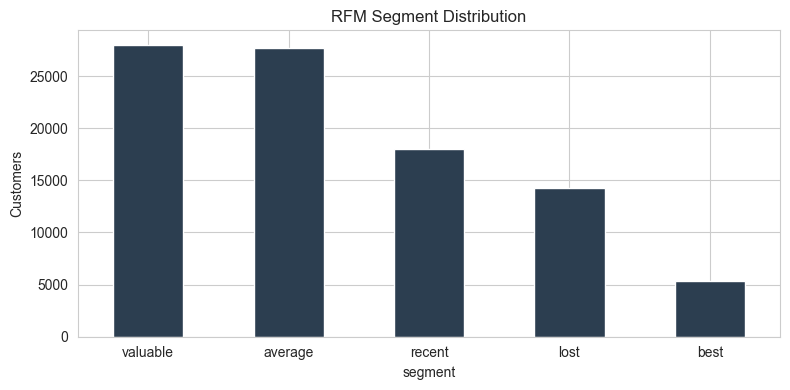

In [64]:
# Segment distribution
fig, ax = plt.subplots(figsize=(8, 4))
segment_summary["customers"].plot(kind="bar", ax=ax, color="#2c3e50")
ax.set_ylabel("Customers")
ax.set_title("RFM Segment Distribution")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

As expected, most customers fall into "average" or "lost" (haven't purchased recently).
The "best" segment is tiny — the few repeat, high-value, recent customers.
In a real scenario, you'd target the "recent" segment for retention campaigns.

## 14. Putting It Together

Let's look at what correlates with review scores at the order level.

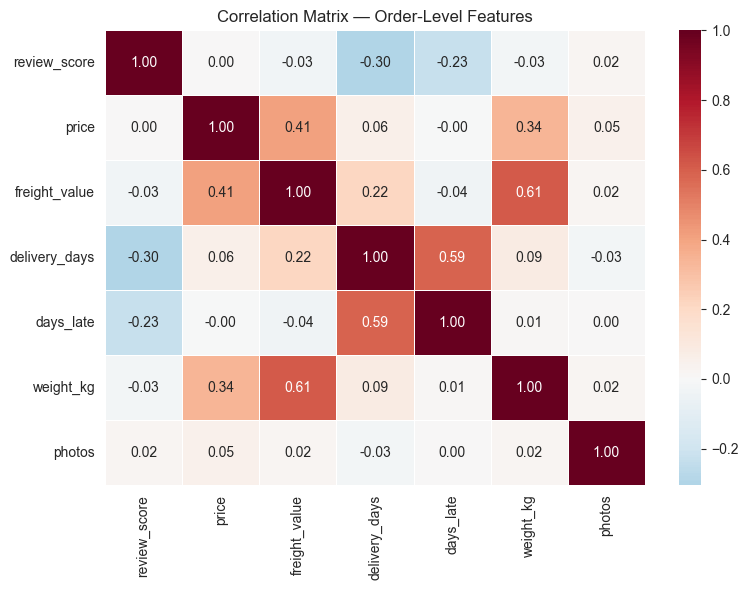

In [65]:
order_features = sql("""
    SELECT
        r.review_score,
        oi.price,
        oi.freight_value,
        EXTRACT(EPOCH FROM (o.order_delivered_customer_date - o.order_purchase_timestamp)) / 86400 AS delivery_days,
        EXTRACT(EPOCH FROM (
            o.order_delivered_customer_date - o.order_estimated_delivery_date
        )) / 86400 AS days_late,
        p.product_weight_g / 1000.0 AS weight_kg,
        p.product_photos_qty AS photos
    FROM orders o
    JOIN order_items oi ON o.order_id = oi.order_id
    JOIN products p ON oi.product_id = p.product_id
    JOIN order_reviews r ON o.order_id = r.order_id
    WHERE o.order_status = 'delivered'
      AND o.order_delivered_customer_date IS NOT NULL
      AND o.order_estimated_delivery_date IS NOT NULL
      AND p.product_weight_g IS NOT NULL
""")

corr_matrix = order_features.corr()

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="RdBu_r", center=0,
            linewidths=0.5, ax=ax)
ax.set_title("Correlation Matrix — Order-Level Features")
plt.tight_layout()
plt.show()

The strongest correlations with `review_score`:
- `days_late` is negatively correlated (the later it is, the worse the review) — confirms our earlier finding
- `delivery_days` also negative — longer delivery = worse review
- `price` and `freight_value` have minimal impact

Delivery experience is by far the biggest driver of customer satisfaction in this marketplace.

## 15. Marketplace Growth — Sellers Over Time

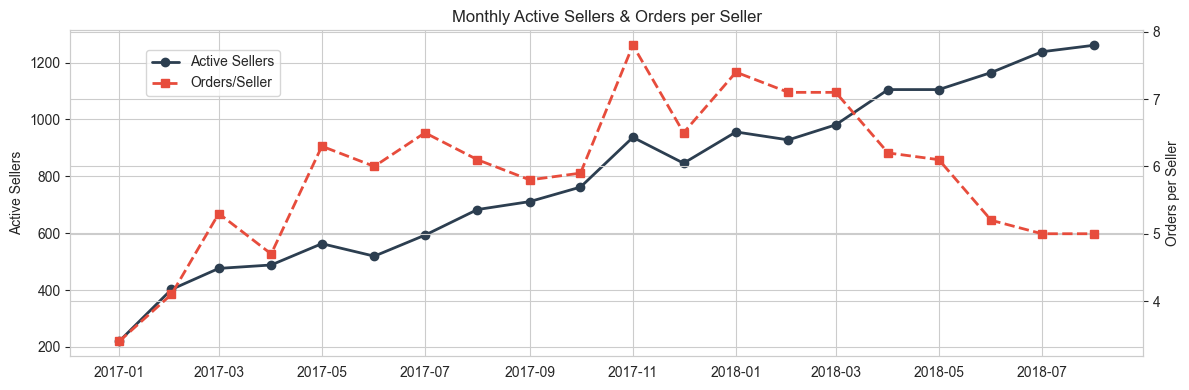

In [66]:
seller_growth = sql("""
    WITH monthly_sellers AS (
        SELECT
            DATE_TRUNC('month', o.order_purchase_timestamp)::date AS month,
            COUNT(DISTINCT oi.seller_id) AS active_sellers,
            COUNT(DISTINCT o.order_id) AS orders
        FROM orders o
        JOIN order_items oi ON o.order_id = oi.order_id
        WHERE o.order_status = 'delivered'
          AND o.order_purchase_timestamp >= '2017-01-01'
          AND o.order_purchase_timestamp < '2018-09-01'
        GROUP BY 1
    )
    SELECT
        *,
        ROUND(orders::numeric / active_sellers, 1) AS orders_per_seller
    FROM monthly_sellers
    ORDER BY 1
""")

fig, ax1 = plt.subplots(figsize=(12, 4))
ax1.plot(seller_growth["month"], seller_growth["active_sellers"], marker="o", color="#2c3e50", linewidth=2, label="Active Sellers")
ax1.set_ylabel("Active Sellers")

ax2 = ax1.twinx()
ax2.plot(seller_growth["month"], seller_growth["orders_per_seller"], marker="s", color="#e74c3c", linewidth=2, linestyle="--", label="Orders/Seller")
ax2.set_ylabel("Orders per Seller")

ax1.set_title("Monthly Active Sellers & Orders per Seller")
fig.legend(loc="upper left", bbox_to_anchor=(0.12, 0.88))
plt.tight_layout()
plt.show()

The number of active sellers has been growing steadily, which means the marketplace is expanding its supply side.
Orders per seller has fluctuated but stayed in a healthy range.

## 16. Order Composition

In [67]:
items_per_order = sql("""
    SELECT
        items_count,
        COUNT(*) AS orders,
        ROUND(100.0 * COUNT(*) / SUM(COUNT(*)) OVER (), 1) AS pct
    FROM (
        SELECT order_id, COUNT(*) AS items_count
        FROM order_items
        GROUP BY 1
    ) sub
    GROUP BY 1
    ORDER BY 1
    LIMIT 10
""")
items_per_order

,items_count,orders,pct
0,1,88863,90.1
1,2,7516,7.6
2,3,1322,1.3
3,4,505,0.5
4,5,204,0.2
5,6,198,0.2
6,7,22,0.0
7,8,8,0.0
8,9,3,0.0
9,10,8,0.0


~87% of orders have just 1 item. Multi-item orders are rare — this is a marketplace, not a grocery store.
People come for a specific product.

In [68]:
# Do multi-item orders get different reviews?
sql("""
    SELECT
        CASE WHEN oi_count = 1 THEN '1 item'
             WHEN oi_count = 2 THEN '2 items'
             ELSE '3+ items' END AS basket_size,
        COUNT(*) AS orders,
        ROUND(AVG(r.review_score)::numeric, 2) AS avg_review,
        ROUND(AVG(total_price)::numeric, 2) AS avg_total
    FROM (
        SELECT
            oi.order_id,
            COUNT(*) AS oi_count,
            SUM(oi.price) AS total_price
        FROM order_items oi
        GROUP BY 1
    ) basket
    JOIN orders o ON basket.order_id = o.order_id
    LEFT JOIN order_reviews r ON o.order_id = r.order_id
    WHERE o.order_status = 'delivered'
    GROUP BY 1
    ORDER BY 1
""")

,basket_size,orders,avg_review,avg_total
0,1 item,87298,4.21,129.52
1,2 items,7446,3.69,174.00
2,3+ items,2263,3.46,299.35


Multi-item orders have slightly lower reviews. Possibly because having more items increases the chance
that at least one has an issue.

## Summary

Key takeaways from this analysis:

1. **Growth**: The marketplace grew significantly from 2017 to 2018, with clear seasonal spikes (Black Friday).

2. **Geography**: São Paulo dominates — ~42% of GMV from customers, most sellers based there too. Northern states have worse logistics.

3. **Payments**: Credit cards account for ~74% of transactions. Installment payments are common (up to 10 months), especially for expensive items.

4. **Delivery is everything**: Late delivery drops review scores from ~4.2 to ~2.5 stars. This is the single biggest driver of customer satisfaction. Estimates are generally conservative, but when they miss, the impact is severe.

5. **Low retention**: ~97% of customers buy only once. This is normal for a general marketplace — people come for specific items, not to browse regularly.

6. **Freight matters**: Shipping costs are ~20% of GMV and can be 30-40% of the item price for cheap products. This likely suppresses purchases of low-value items.

7. **Seller concentration**: Pareto distribution — top 20% of sellers generate ~80% of revenue. A few star sellers carry the marketplace.

8. **Reviews are bimodal**: People either give 5 stars or 1 star. Written comments correlate with lower scores — people write when they're upset.

Potential follow-ups:
- Predict which orders are likely to be delivered late (using product weight, seller location, time of year)
- Build a recommendation system based on cross-category purchase patterns
- Deeper NLP analysis on review text to extract common complaints